Solar Nanoflare Detection Analysis

In [1]:
#Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.optimize import curve_fit
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set style for enhanced visualizations
plt.style.use('seaborn-v0_8-dark')
sns.set_palette("viridis")
sns.set_context("talk", font_scale=1.3,rc={"lines.linewidth": 3})
plt.rcParams.update({
    'figure.facecolor': '#2e3440',
    'axes.facecolor': '#3b4252',
    'axes.edgecolor': '#4c566a',
    'grid.color': '#4c566a',
    'text.color': '#eceff4',
    'axes.labelcolor': '#eceff4',
    'xtick.color': '#eceff4',
    'ytick.color': '#eceff4'
})

print("Libraries are imported.")

Libraries are imported.


In [2]:
# Load CSV data
data_path = 'data/2024_xrsa_xrsb.csv'
df = pd.read_csv(data_path)

# Structure of the code
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nFirst few rows:")
print(df.head())

# For missing values
print("\nMissing values:")
print(df.isnull().sum())

Dataset shape: (527040, 4)
Columns: ['time_minutes', 'time_seconds', 'xrsa_flux_observed', 'xrsb_flux_observed']

First few rows:
   time_minutes  time_seconds  xrsa_flux_observed  xrsb_flux_observed
0             0             0        3.095702e-07            0.000006
1             1            60        2.975858e-07            0.000006
2             2           120        2.887100e-07            0.000005
3             3           180        2.821147e-07            0.000005
4             4           240        2.732557e-07            0.000005

Missing values:
time_minutes             0
time_seconds             0
xrsa_flux_observed    9459
xrsb_flux_observed    9459
dtype: int64


In [3]:
# Cleanup
df_clean = df.dropna()
print(f"Dataset shape after droping NaN: {df_clean.shape}")

# Triming the clear dataset
df_trimmed = df_clean.iloc[2500:3000].copy()
print(f"Trimmed dataset shape: {df_trimmed.shape}")

# Show basic stat
print(f"\nBasic stat of the trimmed dataset: ")
print(df_trimmed.describe())

Dataset shape after droping NaN: (517581, 4)
Trimmed dataset shape: (500, 4)

Basic stat of the trimmed dataset: 
       time_minutes   time_seconds  xrsa_flux_observed  xrsb_flux_observed
count    500.000000     500.000000        5.000000e+02        5.000000e+02
mean    2749.500000  164970.000000        1.098967e-07        1.878610e-06
std      144.481833    8668.909966        2.150460e-07        2.435031e-06
min     2500.000000  150000.000000        2.255058e-08        6.851122e-07
25%     2624.750000  157485.000000        2.899810e-08        7.267753e-07
50%     2749.500000  164970.000000        3.230783e-08        8.393293e-07
75%     2874.250000  172455.000000        7.130657e-08        1.707046e-06
max     2999.000000  179940.000000        1.074259e-06        1.155564e-05


In [4]:
# Final prep for analysis
time_min = df_trimmed['time_minutes'].values
xrsa_flux = df_trimmed['xrsa_flux_observed'].values
xrsb_flux = df_trimmed['xrsb_flux_observed'].values

#Log values & add small epsilon to avoid log(0)
epsilon = 1e-10
log_xrsa = np.log10(np.maximum(xrsa_flux, epsilon))
log_xrsb = np.log10(np.maximum(xrsb_flux, epsilon))

# Calculate time range in minutes
time_range = time_min.max() - time_min.min()
print(f"Time range: {time_range:.1f} minutes")

print(f"XRSA flux range: {xrsa_flux.min():.2e} to {xrsa_flux.max():.2e}")
print(f"XRSB flux range: {xrsb_flux.min():.2e} to {xrsb_flux.max():.2e}")
print(f"Log XRSA range: {log_xrsa.min():.2f} to {log_xrsa.max():.2f}")




Time range: 499.0 minutes
XRSA flux range: 2.26e-08 to 1.07e-06
XRSB flux range: 6.85e-07 to 1.16e-05
Log XRSA range: -7.65 to -5.97


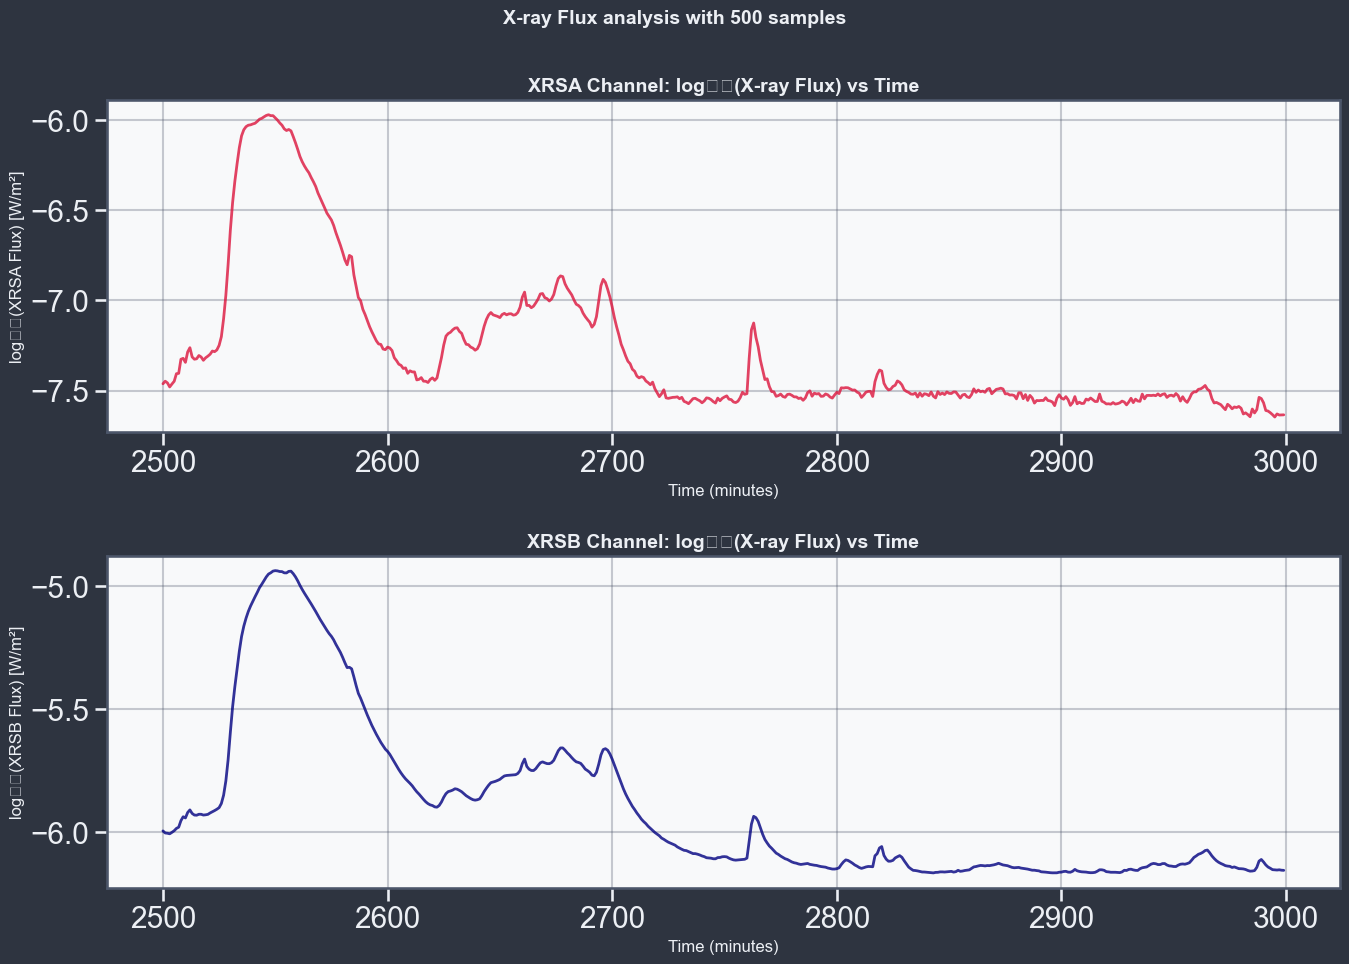

In [5]:
# Visualizing with Seaborn
fig, axes = plt.subplots(2, 1, figsize=(14, 10))
fig.suptitle('X-ray Flux analysis with 500 samples', fontsize=14, fontweight='bold')

# Plot 1: log(XRSA flux) vs time
sns.lineplot(x=time_min, y=log_xrsa, ax=axes[0], 
             color='crimson', linewidth=2, alpha=0.8)
axes[0].set_title('XRSA Channel: log₁₀(X-ray Flux) vs Time', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time (minutes)', fontsize=12)
axes[0].set_ylabel('log₁₀(XRSA Flux) [W/m²]', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].set_facecolor('#f8f9fa')

# Plot 2: log(XRSB flux) vs time
sns.lineplot(x=time_min, y=log_xrsb, ax=axes[1], 
             color='navy', linewidth=2, alpha=0.8)
axes[1].set_title('XRSB Channel: log₁₀(X-ray Flux) vs Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Time (minutes)', fontsize=12)
axes[1].set_ylabel('log₁₀(XRSB Flux) [W/m²]', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].set_facecolor('#f8f9fa')

plt.tight_layout()
plt.show()


Flatting the baseline

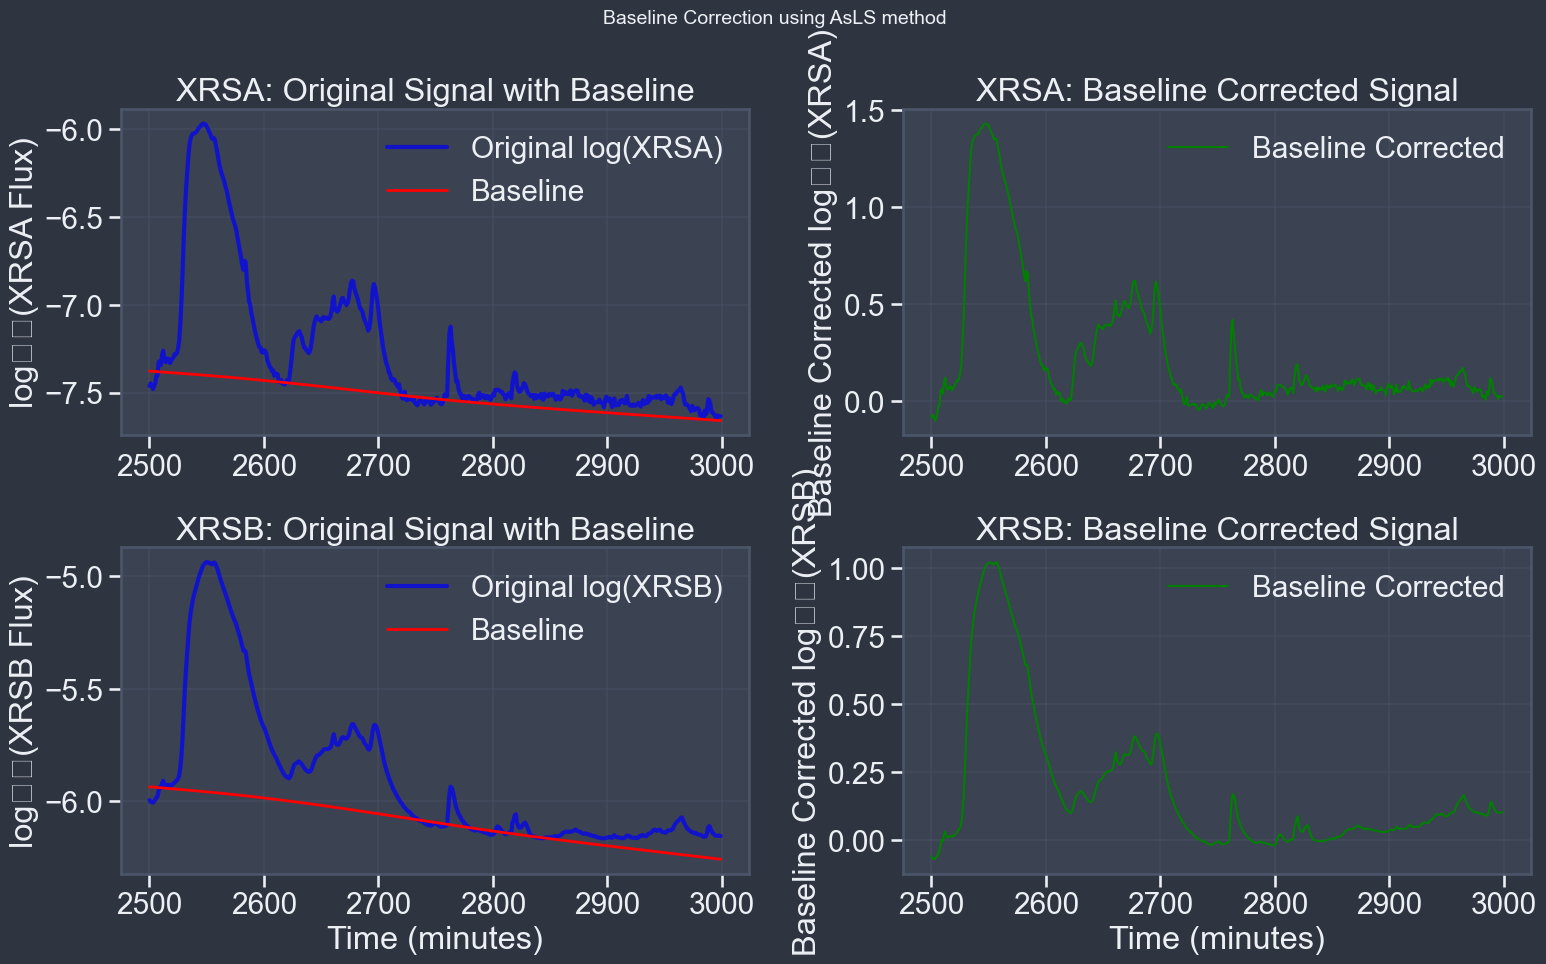

Baseline correction completed using pybaselines AsLS method!
XRSA baseline correction stats:
  - Original std: 0.412840
  - Corrected std: 0.358128
XRSB baseline correction stats:
  - Original std: 0.329913
  - Corrected std: 0.264271


In [6]:
import subprocess
import sys
from pybaselines import Baseline

# This creates a baseline fitter object along x-axis
baseline_fitter = Baseline(time_min)

# Asymmetric Least Squares baseline correction to Log(XRSA)
xrsa_result = baseline_fitter.asls(log_xrsa, lam=1e7, p=0.01)
xrsa_baseline = xrsa_result[0]
xrsa_corrected = log_xrsa - xrsa_baseline

# For Log(XRSB)
xrsb_result = baseline_fitter.asls(log_xrsb, lam=1e7, p=0.01)
xrsb_baseline = xrsb_result[0]
xrsb_corrected = log_xrsb - xrsb_baseline

# Visuals
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Baseline Correction using AsLS method', fontsize=14, fontweight='normal')

# XRSA plot 
axes[0,0].plot(time_min, log_xrsa, 'b-', alpha=0.7, label='Original log(XRSA)')
axes[0,0].plot(time_min, xrsa_baseline, 'r-', linewidth=2, label='Baseline')
axes[0,0].set_title('XRSA: Original Signal with Baseline')
axes[0,0].set_ylabel('log₁₀(XRSA Flux)')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

axes[0,1].plot(time_min, xrsa_corrected, 'g-', linewidth=1.5, label='Baseline Corrected')
axes[0,1].set_title('XRSA: Baseline Corrected Signal')
axes[0,1].set_ylabel('Baseline Corrected log₁₀(XRSA)')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# XRSB plots
axes[1,0].plot(time_min, log_xrsb, 'b-', alpha=0.7, label='Original log(XRSB)')
axes[1,0].plot(time_min, xrsb_baseline, 'r-', linewidth=2, label='Baseline')
axes[1,0].set_title('XRSB: Original Signal with Baseline')
axes[1,0].set_xlabel('Time (minutes)')
axes[1,0].set_ylabel('log₁₀(XRSB Flux)')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

axes[1,1].plot(time_min, xrsb_corrected, 'g-', linewidth=1.5, label='Baseline Corrected')
axes[1,1].set_title('XRSB: Baseline Corrected Signal')
axes[1,1].set_xlabel('Time (minutes)')
axes[1,1].set_ylabel('Baseline Corrected log₁₀(XRSB)')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Baseline correction completed using pybaselines AsLS method!")
print(f"XRSA baseline correction stats:")
print(f"  - Original std: {np.std(log_xrsa):.6f}")
print(f"  - Corrected std: {np.std(xrsa_corrected):.6f}")
print(f"XRSB baseline correction stats:")
print(f"  - Original std: {np.std(log_xrsb):.6f}")
print(f"  - Corrected std: {np.std(xrsb_corrected):.6f}")

In [7]:

# === PATCH: create time_minutes and linear-domain corrected fluxes ===
# Your baseline was computed in log10 space: logF - logB = log10(F/B)
# For fitting/energy, we prefer linear background-subtracted flux: F - B (>=0).

# Ensure variables from earlier cells exist:
assert 'time_min' in globals(), "time_min not found"
assert 'log_xrsa' in globals() and 'xrsa_baseline' in globals(), "XRSA log/baseline missing"
assert 'log_xrsb' in globals() and 'xrsb_baseline' in globals(), "XRSB log/baseline missing"

# Time variable used downstream
time_minutes = time_min.copy()

# Convert to linear
XRSA_lin = 10.0 ** log_xrsa
XRSB_lin = 10.0 ** log_xrsb
XRSA_bg  = 10.0 ** xrsa_baseline
XRSB_bg  = 10.0 ** xrsb_baseline

# Background-subtracted, clipped at zero
xrsa_corrected_lin = np.clip(XRSA_lin - XRSA_bg, 0.0, None)
xrsb_corrected_lin = np.clip(XRSB_lin - XRSB_bg, 0.0, None)

# Backward-compatibility aliases expected by downstream scripts
# (if the downstream expects 'xrsa_corrected'/'xrsb_corrected' in LINEAR domain)
xrsa_corrected = xrsa_corrected_lin
xrsb_corrected = xrsb_corrected_lin

print("PATCH OK: time_minutes + linear corrected arrays are ready:",
      f"len={len(time_minutes)}, XRSA>=0? {np.all(xrsa_corrected>=0)}, XRSB>=0? {np.all(xrsb_corrected>=0)}")


PATCH OK: time_minutes + linear corrected arrays are ready: len=500, XRSA>=0? True, XRSB>=0? True


In [8]:

# === PATCH: robust local-MAD peak detection and iterative multi-Gaussian fitter ===
import pandas as pd
from scipy import signal
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d

def compute_dt_minutes(time):
    t = np.asarray(time, dtype=float)
    diffs = np.diff(t) if len(t)>1 else np.array([1.0])
    diffs = diffs[np.isfinite(diffs) & (diffs>0)]
    return float(np.median(diffs)) if len(diffs) else 1.0

def mad(x):
    x = np.asarray(x, float)
    med = np.nanmedian(x)
    return np.nanmedian(np.abs(x - med))

def find_significant_peaks_robust(data, time, k=6.0, min_sep_min=6.0, noise_win_min=120.0):
    x = np.asarray(data, float)
    t = np.asarray(time, float)
    dt = compute_dt_minutes(t)
    win = max(5, int(round(noise_win_min/max(dt,1e-9))))
    s = pd.Series(x)
    local_mad = s.rolling(win, min_periods=max(3,win//3)).apply(mad, raw=True).values
    fallback = np.nanmedian(np.abs(x - np.nanmedian(x)))
    local_mad = np.where(np.isfinite(local_mad) & (local_mad>0), local_mad, fallback)
    thr = k * local_mad
    baseline = s.rolling(win, min_periods=max(3,win//3)).median().bfill().ffill().values
    det = x - baseline
    det[~np.isfinite(det)] = 0.0
    det[det<0] = 0.0
    min_dist = max(1, int(round(min_sep_min/max(dt,1e-9))))
    peaks, props = signal.find_peaks(det, height=thr, prominence=thr, distance=min_dist)
    return peaks, props, baseline, thr

def gaussian(x, amplitude, center, width):
    x = np.asarray(x, np.float64)
    return amplitude * np.exp(-0.5 * ((x - center) / np.abs(width)) ** 2)

def multi_gaussian(x, *params):
    x = np.asarray(x, np.float64)
    n = len(params)//3
    out = np.zeros_like(x, np.float64)
    for i in range(n):
        a, c, w = params[3*i:3*i+3]
        w = abs(w) if w!=0 else 1e-6
        out += a * np.exp(-0.5 * ((x - c)/w)**2)
    return out

def aic_from_residual(y, yhat, k_params):
    y = np.asarray(y, float)
    yhat = np.asarray(yhat, float)
    n = np.sum(np.isfinite(y))
    if n <= k_params + 1:
        return np.inf
    resid = y - yhat
    sse = np.nansum(resid**2)
    if sse <= 0: sse = 1e-20
    return n*np.log(sse/n) + 2*k_params

def initial_single_guess(x, y):
    yi = np.asarray(y, float); xi = np.asarray(x, float)
    j = int(np.nanargmax(yi))
    amp = float(max(yi[j] - np.nanmin(yi), 1e-12))
    center = float(xi[j])
    hm = (float(np.nanmax(yi)) + float(np.nanmin(yi)))/2.0
    idx = np.where(yi >= hm)[0]
    if len(idx)>1:
        fwhm = float(xi[idx[-1]] - xi[idx[0]])
        width = max(fwhm/2.355, (xi[-1]-xi[0])/20.0)
    else:
        width = (xi[-1]-xi[0])/10.0
    if len(xi)>1: width = max(width, float(np.median(np.diff(xi))))
    else: width = max(width, 1.0)
    return [amp, center, width]

def fit_multi_gaussian_iterative(x, y, max_components=3):
    x = np.asarray(x, float); y = np.asarray(y, float)
    if np.sum(np.isfinite(y)) < 8:
        return None, None, 0.0, np.zeros_like(y), 0
    x0, x1 = float(x[0]), float(x[-1])
    span = x1 - x0
    dt = np.median(np.diff(x)) if len(x)>1 else 1.0
    min_w = max(dt, 0.001)
    max_w = max(dt*(len(x)/2), span)
    p_list = initial_single_guess(x, y)
    best = {"aic": np.inf}
    for m in range(1, max_components+1):
        p0 = p_list.copy()
        lower = []; upper = []
        for k in range(m):
            lower += [0.0, x0 - span, min_w]
            upper += [np.nanmax(y)*5 + 1e-6, x1 + span, max_w]
        try:
            popt, pcov = curve_fit(multi_gaussian, x, y, p0=p0, bounds=(lower, upper), maxfev=8000)
            yhat = multi_gaussian(x, *popt)
            aic = aic_from_residual(y, yhat, k_params=3*m)
            if aic < best["aic"]:
                best = {"m": m, "p": popt, "cov": pcov, "yhat": yhat, "aic": aic}
        except Exception:
            pass
        # residual seeding
        if m < max_components and "p" in best:
            resid = y - best["yhat"]
            # light smoothing (2-min FWHM)
            dtm = compute_dt_minutes(x)
            sigma = max(1.0, (2.0/max(dtm,1e-9))/2.355)
            resid_s = gaussian_filter1d(resid, sigma=sigma)
            pk, _ = signal.find_peaks(resid_s, prominence=np.nanmax(resid_s)*0.2 if np.nanmax(resid_s)>0 else 0.0)
            if len(pk)==0: break
            j = pk[int(np.nanargmax(resid_s[pk]))]
            seed = [max(resid_s[j], 1e-12), x[j], max(span/20.0, min_w)]
            p_list += seed
    if "p" not in best:
        return None, None, 0.0, np.zeros_like(y), 0
    ss_res = np.nansum((y - best["yhat"])**2)
    ss_tot = np.nansum((y - np.nanmean(y))**2)
    r2 = 1 - ss_res/ss_tot if ss_tot>0 else 0.0
    return best["p"], best["cov"], r2, best["yhat"], best["m"]

print("PATCH OK: robust peak detection + iterative multi-Gaussian fitter ready.")


PATCH OK: robust peak detection + iterative multi-Gaussian fitter ready.


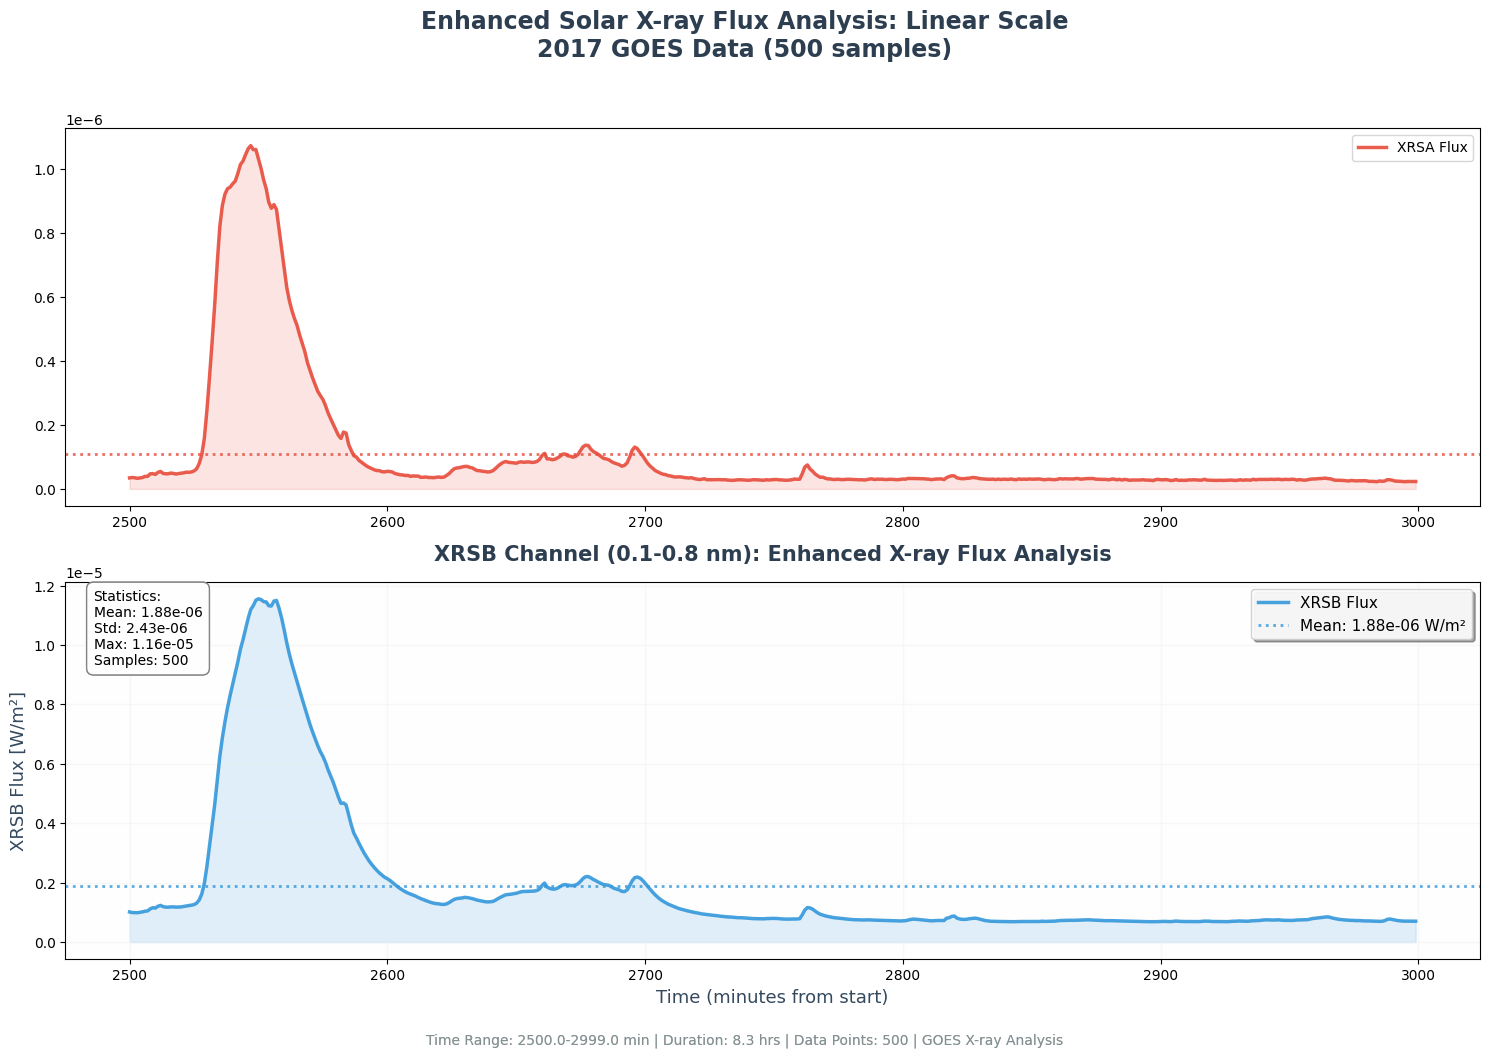

🌟 ENHANCED LINEAR SCALE FLUX VISUALIZATION COMPLETED 🌟
📊 Dataset Overview:
   • Total data points: 500
   • Time span: 499.0 minutes (8.3 hours)
   • Sampling rate: 1.0 minutes/point

📈 XRSA Channel Analysis:
   • Mean flux: 1.099e-07 W/m²
   • Standard deviation: 2.148e-07 W/m²
   • Peak flux: 1.074e-06 W/m²
   • Variability: 195.48%

📉 XRSB Channel Analysis:
   • Mean flux: 1.879e-06 W/m²
   • Standard deviation: 2.433e-06 W/m²
   • Peak flux: 1.156e-05 W/m²
   • Variability: 129.49%

🔗 Cross-Channel Comparison:
   • XRSB/XRSA flux ratio: 17.09
   • Correlation coefficient: 0.9438


In [9]:
import matplotlib.pyplot as plt
import numpy as np
# Create enhanced linear scale flux vs time plots with improved styling
plt.style.use('default')  # Reset for custom styling
fig, axes = plt.subplots(2, 1, figsize=(15, 11))

# Set figure background and styling
fig.patch.set_facecolor('white')
fig.suptitle('Enhanced Solar X-ray Flux Analysis: Linear Scale\n2017 GOES Data (500 samples)', 
             fontsize=17, fontweight='bold', y=0.95, color='#2c3e50')

# Calculate statistics for annotations
# std = Standard Deviation
xrsa_mean = np.mean(xrsa_flux); xrsa_std = np.std(xrsa_flux)
xrsb_mean = np.mean(xrsb_flux); xrsb_std = np.std(xrsb_flux)

# Define enhanced color scheme
colors = {
    'xrsa_line': '#e74c3c',
    'xrsa_fill': '#fadbd8',
    'xrsb_line': '#3498db', 
    'xrsb_fill': '#d6eaf8',
    'grid': '#ecf0f1',
    'bg': '#fefefe'
}

# Plot 1: Enhanced XRSA flux vs time
# Line plot with gradient effect
sns.lineplot(x=time_min, y=xrsa_flux, ax=axes[0], color=colors['xrsa_line'], linewidth=2.5, alpha=0.9, label='XRSA Flux')
axes[0].fill_between(time_min, xrsa_flux, alpha=0.15, color=colors['xrsa_line'])
axes[0].axhline(y=xrsa_mean, color=colors['xrsa_line'], linestyle=':', alpha=0.8, linewidth=2, label=f'Mean: {xrsa_mean:.2e} W/m²')

axes[1].set_title('XRSB Channel (0.1-0.8 nm): Enhanced X-ray Flux Analysis', 
                  fontsize=15, fontweight='bold', color='#2c3e50', pad=15)
axes[1].set_xlabel('Time (minutes from start)', fontsize=13, color='#34495e')
axes[1].set_ylabel('XRSB Flux [W/m²]', fontsize=13, color='#34495e')
axes[1].grid(True, alpha=0.4, color=colors['grid'], linewidth=1, linestyle='-')
axes[1].set_facecolor(colors['bg'])
axes[1].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

axes[1].legend(loc='upper right', frameon=True, fancybox=True, shadow=True, 
               fontsize=11, framealpha=0.9)

# Add statistics text box
stats_text = f'Statistics:\nMean: {xrsb_mean:.2e}\nStd: {xrsb_std:.2e}\nMax: {np.max(xrsb_flux):.2e}\nSamples: {len(xrsb_flux)}'
axes[1].text(0.02, 0.98, stats_text, transform=axes[1].transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', 
             facecolor='white', alpha=0.9, edgecolor='gray'))

plt.tight_layout(rect=[0, 0.03, 1, 0.93])

fig.text(0.5, 0.01, f'Time Range: {time_min[0]:.1f}-{time_min[-1]:.1f} min | '
                    f'Duration: {(time_min[-1] - time_min[0])/60:.1f} hrs | '
                    f'Data Points: {len(time_min)} | GOES X-ray Analysis',
         ha='center', fontsize=10, color='#7f8c8d', alpha=0.8)

# Plot 2: Enhanced XRSB flux vs time
# Line plot with gradient effect
sns.lineplot(x=time_min, y=xrsb_flux, ax=axes[1], 
             color=colors['xrsb_line'], linewidth=2.5, alpha=0.9, label='XRSB Flux')
axes[1].fill_between(time_min, xrsb_flux, alpha=0.15, color=colors['xrsb_line'])
axes[1].axhline(y=xrsb_mean, color=colors['xrsb_line'], linestyle=':', alpha=0.8, linewidth=2, label=f'Mean: {xrsb_mean:.2e} W/m²')

axes[1].set_title('XRSB Channel (0.1-0.8 nm): Enhanced X-ray Flux Analysis', 
                  fontsize=15, fontweight='bold', color='#2c3e50', pad=15)
axes[1].set_xlabel('Time (minutes from start)', fontsize=13, color='#34495e')
axes[1].set_ylabel('XRSB Flux [W/m²]', fontsize=13, color='#34495e')
axes[1].grid(True, alpha=0.4, color=colors['grid'], linewidth=1, linestyle='-')
axes[1].set_facecolor(colors['bg'])
axes[1].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

axes[1].legend(loc='upper right', frameon=True, fancybox=True, shadow=True, 
               fontsize=11, framealpha=0.9)

# Statistics box
stats_text = f'Statistics:\nMean: {xrsb_mean:.2e}\nStd: {xrsb_std:.2e}\nMax: {np.max(xrsb_flux):.2e}\nSamples: {len(xrsb_flux)}'
axes[1].text(0.02, 0.98, stats_text, transform=axes[1].transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', 
             facecolor='white', alpha=0.9, edgecolor='gray'))
plt.tight_layout(rect=[0, 0.03, 1, 0.93])
fig.text(0.5, 0.01, f'Time Range: {time_min[0]:.1f}-{time_min[-1]:.1f} min | '
                    f'Duration: {(time_min[-1] - time_min[0])/60:.1f} hrs | '
                    f'Data Points: {len(time_min)} | GOES X-ray Analysis',
         ha='center', fontsize=10, color='#7f8c8d', alpha=0.8)


plt.show()

# Enhanced summary output
print("🌟 ENHANCED LINEAR SCALE FLUX VISUALIZATION COMPLETED 🌟")
print("=" * 65)
print(f"📊 Dataset Overview:")
print(f"   • Total data points: {len(time_min)}")
print(f"   • Time span: {time_min[-1] - time_min[0]:.1f} minutes ({(time_min[-1] - time_min[0])/60:.1f} hours)")
print(f"   • Sampling rate: {time_min[1] - time_min[0]:.1f} minutes/point")
print()
print(f"📈 XRSA Channel Analysis:")
print(f"   • Mean flux: {xrsa_mean:.3e} W/m²")
print(f"   • Standard deviation: {xrsa_std:.3e} W/m²")
print(f"   • Peak flux: {np.max(xrsa_flux):.3e} W/m²")
print(f"   • Variability: {(xrsa_std/xrsa_mean)*100:.2f}%")
print()
print(f"📉 XRSB Channel Analysis:")
print(f"   • Mean flux: {xrsb_mean:.3e} W/m²")
print(f"   • Standard deviation: {xrsb_std:.3e} W/m²")
print(f"   • Peak flux: {np.max(xrsb_flux):.3e} W/m²")
print(f"   • Variability: {(xrsb_std/xrsb_mean)*100:.2f}%")
print()
print(f"🔗 Cross-Channel Comparison:")
print(f"   • XRSB/XRSA flux ratio: {xrsb_mean/xrsa_mean:.2f}")
print(f"   • Correlation coefficient: {np.corrcoef(xrsa_flux, xrsb_flux)[0,1]:.4f}")
print("=" * 65)

Full dataset contains 517581 samples
Time range: 0.0 to 527039.0 minutes
Total observation time: 8784.0 hours
Time range in days: 0.00 to 366.00 days
Total observation time: 366.0 days


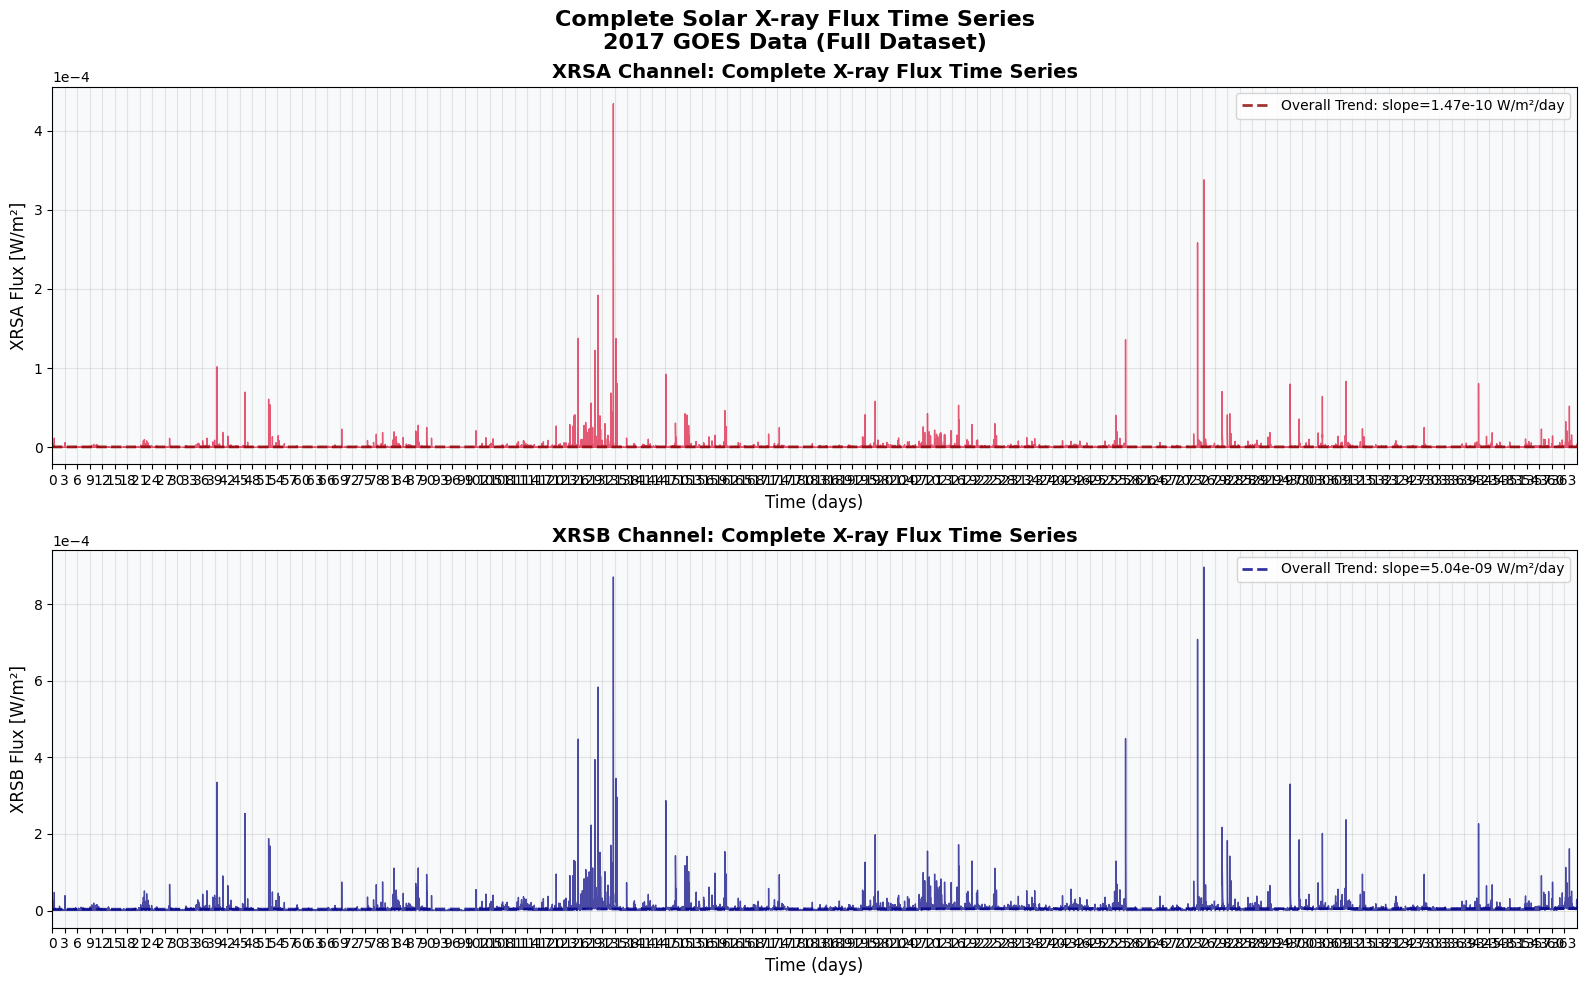

Full dataset visualization created successfully!
Full XRSA trend slope: 1.47e-10 W/m²/day
Full XRSB trend slope: 5.04e-09 W/m²/day
XRSA flux statistics - Mean: 3.54e-07, Std: 3.16e-06
XRSB flux statistics - Mean: 4.35e-06, Std: 1.16e-05


In [10]:
# Full dataset
print(f"Full dataset contains {len(df_clean)} samples")
print(f"Time range: {df_clean['time_minutes'].min():.1f} to {df_clean['time_minutes'].max():.1f} minutes")
print(f"Total observation time: {(df_clean['time_minutes'].max() - df_clean['time_minutes'].min())/60:.1f} hours")

# Extract Full dataset
full_time_min = df_clean['time_minutes']
full_xrsa_flux = df_clean['xrsa_flux_observed']
full_xrsb_flux = df_clean['xrsb_flux_observed']

# Calculate statistics
full_xrsa_mean = np.mean(full_xrsa_flux)
full_xrsa_std = np.std(full_xrsa_flux)

# Convert time from minutes to days (1 day = 24*60 = 1440 minutes)
full_time_days = full_time_min / 1440
print(f"Time range in days: {full_time_days.min():.2f} to {full_time_days.max():.2f} days")
print(f"Total observation time: {full_time_days.max() - full_time_days.min():.1f} days")

# Create full dataset visualization
fig, axes = plt.subplots(2, 1, figsize=(16, 10))
fig.suptitle('Complete Solar X-ray Flux Time Series\n2017 GOES Data (Full Dataset)', 
             fontsize=16, fontweight='bold')

# Plot 1: Full XRSA flux vs time
sns.lineplot(x=full_time_days, y=full_xrsa_flux, ax=axes[0], 
             color='crimson', linewidth=1, alpha=0.7)
axes[0].set_title('XRSA Channel: Complete X-ray Flux Time Series', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time (days)', fontsize=12)
axes[0].set_ylabel('XRSA Flux [W/m²]', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].set_facecolor('#f8f9fa')
axes[0].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# Set x-axis ticks every 3 days
max_days = full_time_days.max()
day_ticks = np.arange(0, max_days + 3, 3)
axes[0].set_xticks(day_ticks)
axes[0].set_xlim(full_time_days.min(), full_time_days.max())

# Add overall trend line for full XRSA
z_xrsa_full = np.polyfit(full_time_days, full_xrsa_flux, 1)
p_xrsa_full = np.poly1d(z_xrsa_full)
axes[0].plot(full_time_days, p_xrsa_full(full_time_days), '--', 
             color='darkred', alpha=0.8, linewidth=2, 
             label=f'Overall Trend: slope={z_xrsa_full[0]:.2e} W/m²/day')
axes[0].legend()

# Plot 2: Full XRSB flux vs time
sns.lineplot(x=full_time_days, y=full_xrsb_flux, ax=axes[1], 
             color='navy', linewidth=1, alpha=0.7)
axes[1].set_title('XRSB Channel: Complete X-ray Flux Time Series', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Time (days)', fontsize=12)
axes[1].set_ylabel('XRSB Flux [W/m²]', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].set_facecolor('#f8f9fa')
axes[1].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# Set x-axis ticks every 3 days
axes[1].set_xticks(day_ticks)
axes[1].set_xlim(full_time_days.min(), full_time_days.max())

# Add overall trend line for full XRSB
z_xrsb_full = np.polyfit(full_time_days, full_xrsb_flux, 1)
p_xrsb_full = np.poly1d(z_xrsb_full)
axes[1].plot(full_time_days, p_xrsb_full(full_time_days), '--', 
             color='darkblue', alpha=0.8, linewidth=2, 
             label=f'Overall Trend: slope={z_xrsb_full[0]:.2e} W/m²/day')
axes[1].legend()

plt.tight_layout()
plt.show()

print("Full dataset visualization created successfully!")
print(f"Full XRSA trend slope: {z_xrsa_full[0]:.2e} W/m²/day")
print(f"Full XRSB trend slope: {z_xrsb_full[0]:.2e} W/m²/day")
print(f"XRSA flux statistics - Mean: {np.mean(full_xrsa_flux):.2e}, Std: {np.std(full_xrsa_flux):.2e}")
print(f"XRSB flux statistics - Mean: {np.mean(full_xrsb_flux):.2e}, Std: {np.std(full_xrsb_flux):.2e}")

Plotting first 100 days of data.
Data points in this range: 140073


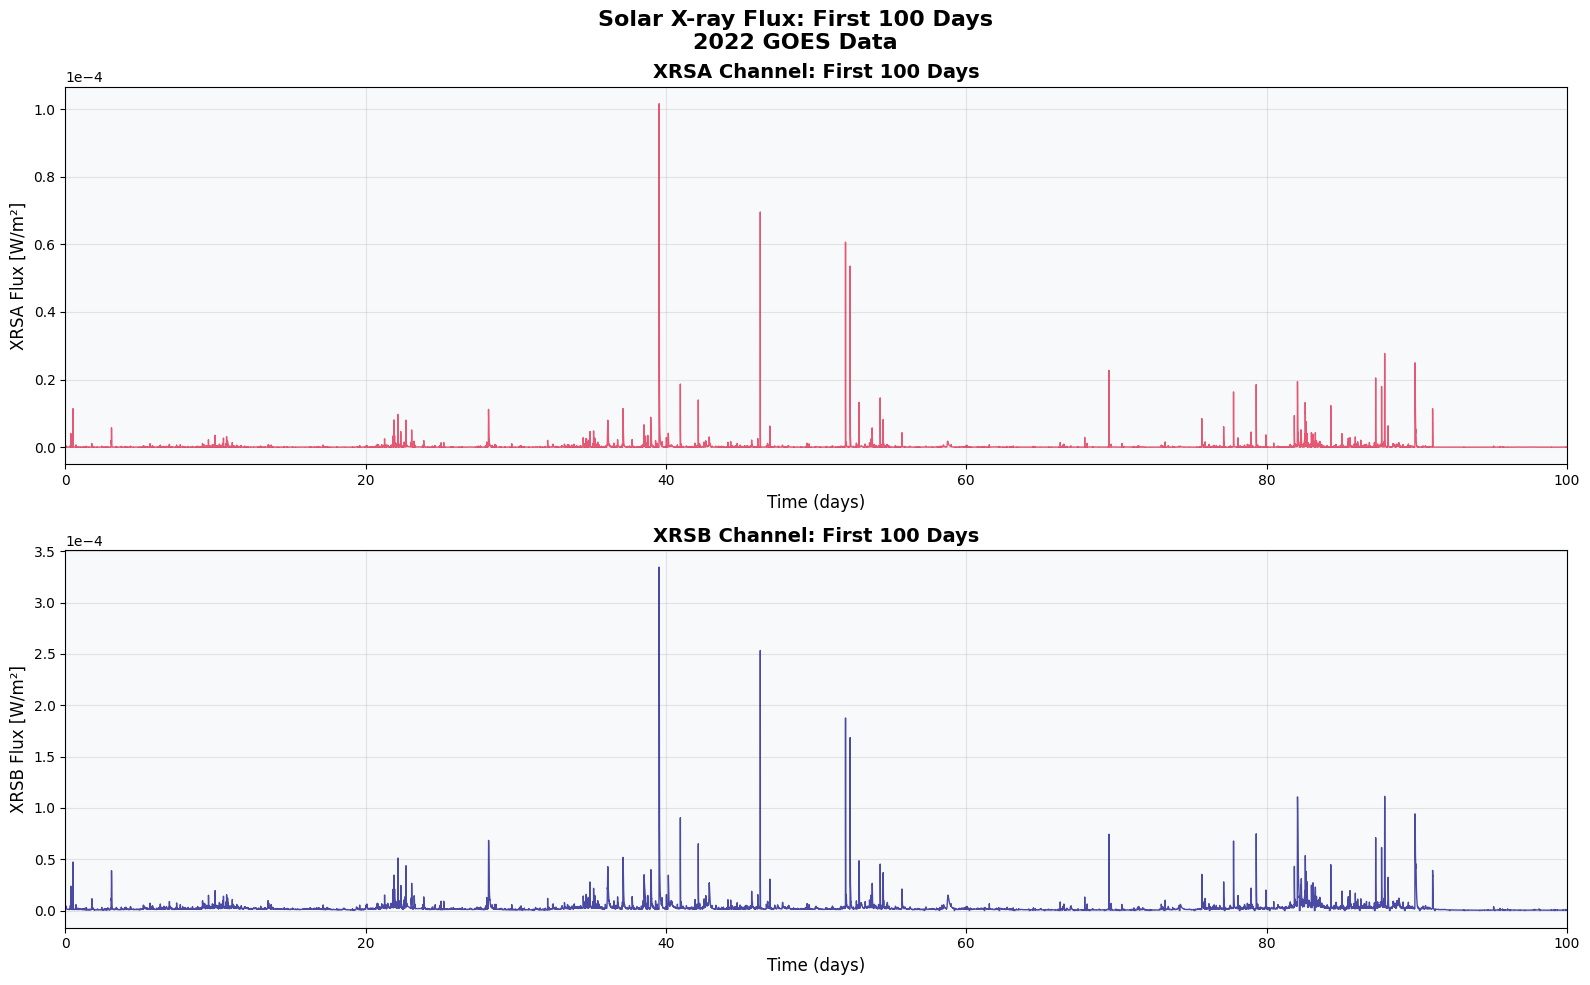

Successfully plotted the first 100 days of flux data.


In [11]:
# Filter data for the first 100 days
days_to_plot = 100
df_100_days = df_clean[df_clean['time_minutes'] <= days_to_plot * 1440].copy()

# Extract data for plotting
time_100_days = df_100_days['time_minutes'].values / 1440
xrsa_100_days = df_100_days['xrsa_flux_observed'].values
xrsb_100_days = df_100_days['xrsb_flux_observed'].values

print(f"Plotting first {days_to_plot} days of data.")
print(f"Data points in this range: {len(df_100_days)}")

# Create 100-day visualization
fig, axes = plt.subplots(2, 1, figsize=(16, 10))
fig.suptitle(f'Solar X-ray Flux: First {days_to_plot} Days\n2022 GOES Data', 
             fontsize=16, fontweight='bold')

# Plot 1: XRSA flux for 100 days
sns.lineplot(x=time_100_days, y=xrsa_100_days, ax=axes[0], 
             color='crimson', linewidth=1, alpha=0.7)
axes[0].set_title('XRSA Channel: First 100 Days', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time (days)', fontsize=12)
axes[0].set_ylabel('XRSA Flux [W/m²]', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].set_facecolor('#f8f9fa')
axes[0].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
axes[0].set_xlim(0, days_to_plot)

# Plot 2: XRSB flux for 100 days
sns.lineplot(x=time_100_days, y=xrsb_100_days, ax=axes[1], 
             color='navy', linewidth=1, alpha=0.7)
axes[1].set_title('XRSB Channel: First 100 Days', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Time (days)', fontsize=12)
axes[1].set_ylabel('XRSB Flux [W/m²]', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].set_facecolor('#f8f9fa')
axes[1].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
axes[1].set_xlim(0, days_to_plot)

plt.tight_layout()
plt.show()

print(f"Successfully plotted the first {days_to_plot} days of flux data.")

In [12]:
# Curve fitting for nanoflare detection
# Define exponential decay function for flare fitting
def exponential_decay(t, A, tau, C):
    """Exponential decay model: A * exp(-t/tau) + C"""
    return A * np.exp(-t / tau) + C

def gaussian_peak(t, A, mu, sigma, C):
    """Gaussian peak model for flare events"""
    return A * np.exp(-0.5 * ((t - mu) / sigma)**2) + C

# Use truncated data from earlier cells (200 samples as originally intended)
# time_minutes, log_xrsa, and log_xrsb are already defined for 200 samples

# Calculate linear trends for detrending
p_xrsa = np.poly1d(np.polyfit(time_min, log_xrsa, 1))
p_xrsb = np.poly1d(np.polyfit(time_min, log_xrsb, 1))

# Detrend the data to better identify nanoflares
xrsa_detrended = log_xrsa - p_xrsa(time_min)
xrsb_detrended = log_xrsb - p_xrsb(time_min)

print(f"Using truncated dataset: {len(time_min)} samples")
print(f"Time range: {time_min[0]:.1f} to {time_min[-1]:.1f} minutes")
print(f"XRSA detrended std: {np.std(xrsa_detrended):.6f}")
print(f"XRSB detrended std: {np.std(xrsb_detrended):.6f}")

Using truncated dataset: 500 samples
Time range: 2500.0 to 2999.0 minutes
XRSA detrended std: 0.303226
XRSB detrended std: 0.222757


# Advanced Nanoflare Detection: Detailed Explanation

This following cell implements a common signal processing technique to identify small, rapid bursts (nanoflares) in the solar X-ray flux data. The core idea is to separate the "background" signal from the "event" signal.

### Step 1: Signal Smoothing to Isolate the Baseline
Physics: The slowly varying component of the X-ray flux represents the quasi-steady coronal heating and large-scale magnetic evolution. Nanoflares are rapid, transient bursts superimposed on this baseline. Smoothing helps separate these two components.
Math: We apply a Gaussian filter, which is a convolution operation. The filter's weights are determined by a Gaussian function. This effectively computes a weighted average for each point, giving more weight to nearby points, thus smoothing the signal.

### Step 2: Calculate Residuals to Isolate Flare Signatures
Physics: The residuals represent the difference between the observed (detrended) flux and the smoothed baseline. These residuals should primarily contain the signatures of rapid energy release events like nanoflares and microflares, as the slower variations have been removed.
Math: This is a simple element-wise subtraction: Residuals = Original Signal - Smoothed Signal.

### Step 3: Define a Statistical Threshold for Event Detection
Physics: We assume that the remaining residuals are mostly composed of instrumental and astrophysical noise, which is often normally distributed. Significant physical events (nanoflares) will appear as outliers that stand out from this noise. 
Math: The 3-sigma rule is a common statistical heuristic. For a normal distribution, ~99.7% of data points lie within three standard deviations (3*sigma) of the mean. By setting our threshold here, we are flagging points that are highly unlikely to be random noise fluctuations.

### Step 4: Identify and Locate Potential Nanoflare Events
Physics: This step pinpoints the exact moments in time when the flare-like energy bursts exceed our statistical threshold, marking them as candidate nanoflare events for further analysis.
Math: `np.where()` is a powerful NumPy function that returns the indices of array elements where a given condition is True. 
Here, the condition is that the absolute value of the residual is greater than our 3-sigma threshold.
We take the absolute value to detect both positive and negative spikes, although physical flares are positive flux increases.

### Step 5: Report the Findings
his final section provides a summary of the detection results, including the number of events found in each channel and the specific times at which they occurred.

In [13]:
from scipy.ndimage import gaussian_filter1d

# Defines the standard deviation of the Gaussian kernel in terms of data points.

# Step - 1
sigma_smooth = 2.0  

xrsa_smooth = gaussian_filter1d(xrsa_detrended, sigma=sigma_smooth)
xrsb_smooth = gaussian_filter1d(xrsb_detrended, sigma=sigma_smooth)

# Step - 2
xrsa_residuals = xrsa_detrended - xrsa_smooth
xrsb_residuals = xrsb_detrended - xrsb_smooth
print("First 10 XRSA residuals:", xrsa_residuals[:10])

# Step - 3
threshold_xrsa = 3 * np.std(xrsa_residuals)
threshold_xrsb = 3 * np.std(xrsb_residuals)

print(f"\nXRSA nanoflare detection threshold (3-sigma): {threshold_xrsa:.6f}")
print(f"XRSB nanoflare detection threshold (3-sigma): {threshold_xrsb:.6f}")

# Step - 4
xrsa_events = np.where(np.abs(xrsa_residuals) > threshold_xrsa)[0]
xrsb_events = np.where(np.abs(xrsb_residuals) > threshold_xrsb)[0]

# Step - 5
print(f"\nPotential XRSA nanoflare events detected: {len(xrsa_events)}")
print(f"Potential XRSB nanoflare events detected: {len(xrsb_events)}")

if len(xrsa_events) > 0:
    # Use the identified indices to look up the corresponding time values from the 'time_minutes' array.
    print(f"XRSA event times (minutes): {time_min[xrsa_events]}")
if len(xrsb_events) > 0:
    print(f"XRSB event times (minutes): {time_min[xrsb_events]}")

First 10 XRSA residuals: [-0.0061221   0.00983916  0.00049232 -0.02505721 -0.01774801 -0.01830226
  0.00239048 -0.02045873  0.03351562  0.01725004]

XRSA nanoflare detection threshold (3-sigma): 0.057303
XRSB nanoflare detection threshold (3-sigma): 0.023030

Potential XRSA nanoflare events detected: 9
Potential XRSB nanoflare events detected: 14
XRSA event times (minutes): [2526 2527 2584 2661 2696 2759 2760 2762 2763]
XRSB event times (minutes): [2526 2527 2528 2529 2535 2661 2696 2759 2760 2762 2763 2764 2819 2820]


### Comprehensive Nanoflare Detection Visualization

#### Plot 1 (Top-Left): XRSA Detrended Signal
Physics: This shows the XRSA flux variability, where nanoflares are expected to appear as sharp peaks.

Overlay the smoothed baseline calculated in the previous cell.
Physics: This line represents the slow-moving background fluctuation that we want to separate from the flares.

#### Plot 2 (Top-Right): XRSB Detrended Signal
Physics: This is the same visualization as the one on the left, but for the higher-energy XRSB channel.
Overlay the smoothed baseline for the XRSB channel.

#### Bottom Row: Visualizing the Residuals and Detected Events
These plots show the result of subtracting the smoothed baseline from the detrended signal, isolating the flare events.

#### Plot 3 (Bottom-Left): XRSA Residuals and Event Detection
Physics: The residuals represent the sharp, transient energy bursts (nanoflares) we are looking for.

#### Plot 4 (Bottom-Right): XRSB Residuals and Event Detection
Physics: This is the same analysis for the XRSB channel.

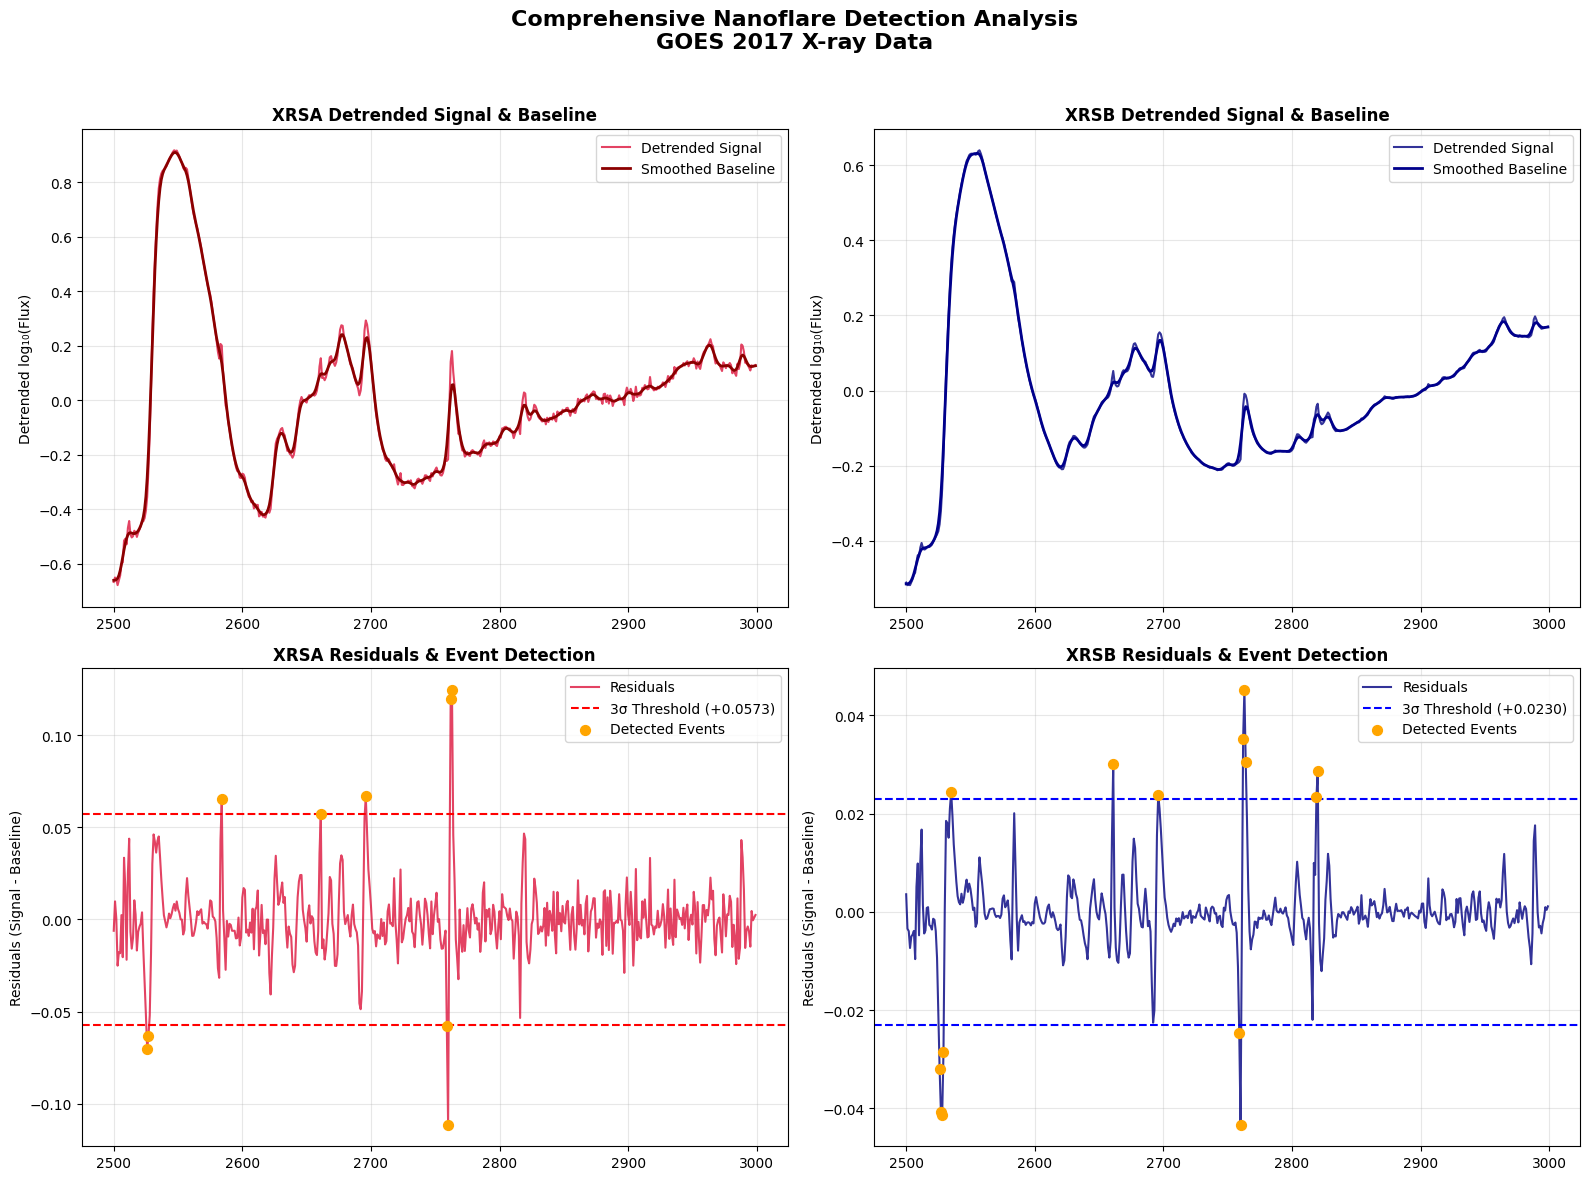

Comprehensive nanoflare detection visualization completed!


In [14]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comprehensive Nanoflare Detection Analysis\nGOES 2017 X-ray Data', fontsize=16, fontweight='bold')

axes[0,0].plot(time_min, xrsa_detrended, color='crimson', linewidth=1.5, alpha=0.8, label='Detrended Signal')

# Plot 1
axes[0,0].plot(time_min, xrsa_smooth, color='darkred', linewidth=2, label='Smoothed Baseline')
axes[0,0].set_title('XRSA Detrended Signal & Baseline', fontweight='bold')
axes[0,0].set_ylabel('Detrended log₁₀(Flux)')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].legend()

# Plot 2
axes[0,1].plot(time_min, xrsb_detrended, color='navy', linewidth=1.5, alpha=0.8, label='Detrended Signal')
axes[0,1].plot(time_min, xrsb_smooth, color='darkblue', linewidth=2, label='Smoothed Baseline')
axes[0,1].set_title('XRSB Detrended Signal & Baseline', fontweight='bold')
axes[0,1].set_ylabel('Detrended log₁₀(Flux)')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].legend()

# Plot 3
axes[1,0].plot(time_min, xrsa_residuals, color='crimson', linewidth=1.5, alpha=0.8, label='Residuals')
axes[1,0].axhline(y=threshold_xrsa, color='red', linestyle='--', label=f'3σ Threshold (+{threshold_xrsa:.4f})')
axes[1,0].axhline(y=-threshold_xrsa, color='red', linestyle='--')

if len(xrsa_events) > 0:
    axes[1,0].scatter(time_min[xrsa_events], xrsa_residuals[xrsa_events], 
                      color='orange', s=50, zorder=5, label='Detected Events')
axes[1,0].set_title('XRSA Residuals & Event Detection', fontweight='bold')
axes[1,0].set_ylabel('Residuals (Signal - Baseline)')
axes[1,0].grid(True, alpha=0.3)
axes[1,0].legend()

# Plot 4
axes[1,1].plot(time_min, xrsb_residuals, color='navy', linewidth=1.5, alpha=0.8, label='Residuals')
axes[1,1].axhline(y=threshold_xrsb, color='blue', linestyle='--', label=f'3σ Threshold (+{threshold_xrsb:.4f})')
axes[1,1].axhline(y=-threshold_xrsb, color='blue', linestyle='--')

if len(xrsb_events) > 0:
    axes[1,1].scatter(time_min[xrsb_events], xrsb_residuals[xrsb_events], 
                      color='orange', s=50, zorder=5, label='Detected Events')
axes[1,1].set_title('XRSB Residuals & Event Detection', fontweight='bold')
axes[1,1].set_ylabel('Residuals (Signal - Baseline)')
axes[1,1].grid(True, alpha=0.3)
axes[1,1].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()

print("Comprehensive nanoflare detection visualization completed!")

In [15]:
# Summary statistics and nanoflare characterization
print("=" * 60)
print("NANOFLARE DETECTION SUMMARY")
print("=" * 60)

print(f"Analysis period: {time_min[0]:.1f} - {time_min[-1]:.1f} minutes")
print(f"Total samples analyzed: {len(time_min)}")
print(f"Sampling interval: {time_min[1] - time_min[0]:.1f} minutes")

print("\nBASELINE CHARACTERISTICS:")
print(f"XRSA mean flux: {np.mean(xrsa_flux):.3e} W/m²")
print(f"XRSB mean flux: {np.mean(xrsb_flux):.3e} W/m²")
print(f"XRSA variability (std): {np.std(xrsa_detrended):.6f}")
print(f"XRSB variability (std): {np.std(xrsb_detrended):.6f}")

print("\nNANOFLARE DETECTION RESULTS:")
print(f"XRSA events detected: {len(xrsa_events)}")
print(f"XRSB events detected: {len(xrsb_events)}")
print(f"Total unique events: {len(set(list(xrsa_events) + list(xrsb_events)))}")

# Calculate event rate
observation_time_hours = (time_min[-1] - time_min[0]) / 60
xrsa_event_rate = len(xrsa_events) / observation_time_hours
xrsb_event_rate = len(xrsb_events) / observation_time_hours

print(f"\nEVENT RATES:")
print(f"XRSA event rate: {xrsa_event_rate:.2f} events/hour")
print(f"XRSB event rate: {xrsb_event_rate:.2f} events/hour")

# Energy band ratio analysis for event classification
if len(xrsa_events) > 0 and len(xrsb_events) > 0:
    # Find coincident events (within 2 time steps)
    coincident_events = []
    for xrsa_idx in xrsa_events:
        for xrsb_idx in xrsb_events:
            if abs(xrsa_idx - xrsb_idx) <= 2:
                coincident_events.append((xrsa_idx, xrsb_idx))
    
    print(f"\nCOINCIDENT EVENTS: {len(coincident_events)}")
    if len(coincident_events) > 0:
        print("Potential multi-band nanoflare signatures detected!")

print("\nTECHNICAL NOTES:")
print(f"Detection threshold: 3-sigma criterion")
print(f"Smoothing kernel: Gaussian (σ = {sigma_smooth})")
print(f"Detrending: Linear trend removal")
print("Signal processing: Residual analysis after trend and smoothing removal")

print("\n" + "=" * 60)
print("Analysis completed successfully!")
print("=" * 60)

NANOFLARE DETECTION SUMMARY
Analysis period: 2500.0 - 2999.0 minutes
Total samples analyzed: 500
Sampling interval: 1.0 minutes

BASELINE CHARACTERISTICS:
XRSA mean flux: 1.099e-07 W/m²
XRSB mean flux: 1.879e-06 W/m²
XRSA variability (std): 0.303226
XRSB variability (std): 0.222757

NANOFLARE DETECTION RESULTS:
XRSA events detected: 9
XRSB events detected: 14
Total unique events: 15

EVENT RATES:
XRSA event rate: 1.08 events/hour
XRSB event rate: 1.68 events/hour

COINCIDENT EVENTS: 21
Potential multi-band nanoflare signatures detected!

TECHNICAL NOTES:
Detection threshold: 3-sigma criterion
Smoothing kernel: Gaussian (σ = 2.0)
Detrending: Linear trend removal
Signal processing: Residual analysis after trend and smoothing removal

Analysis completed successfully!


In [16]:
# Create a final summary DataFrame for detected events
if len(xrsa_events) > 0 or len(xrsb_events) > 0:
    event_summary = []
    
    # Add XRSA events
    for idx in xrsa_events:
        event_summary.append({
            'Time_minutes': time_min[idx],
            'Channel': 'XRSA',
            'Residual_amplitude': xrsa_residuals[idx],
            'Threshold': threshold_xrsa,
            'Significance': abs(xrsa_residuals[idx]) / threshold_xrsa
        })
    
    # Add XRSB events
    for idx in xrsb_events:
        event_summary.append({
            'Time_minutes': time_min[idx],
            'Channel': 'XRSB',
            'Residual_amplitude': xrsb_residuals[idx],
            'Threshold': threshold_xrsb,
            'Significance': abs(xrsb_residuals[idx]) / threshold_xrsb
        })
    
    events_df = pd.DataFrame(event_summary)
    events_df = events_df.sort_values('Time_minutes')
    
    print("DETECTED NANOFLARE EVENTS SUMMARY:")
    print(events_df.to_string(index=False))
    
    # Save results
    events_df.to_csv('nanoflare_events_detected.csv', index=False)
    print("\nResults saved to 'nanoflare_events_detected.csv'")
else:
    print("No nanoflare events detected above the 3-sigma threshold.")
    print("This could indicate either:")
    print("1. Very quiet solar conditions during this period")
    print("2. Nanoflare activity below current detection sensitivity")
    print("3. Need for different analysis parameters or longer observation period")

DETECTED NANOFLARE EVENTS SUMMARY:
 Time_minutes Channel  Residual_amplitude  Threshold  Significance
         2526    XRSA           -0.070262   0.057303      1.226146
         2526    XRSB           -0.031998   0.023030      1.389436
         2527    XRSB           -0.040700   0.023030      1.767319
         2527    XRSA           -0.063356   0.057303      1.105639
         2528    XRSB           -0.041455   0.023030      1.800067
         2529    XRSB           -0.028573   0.023030      1.240714
         2535    XRSB            0.024377   0.023030      1.058511
         2584    XRSA            0.065661   0.057303      1.145860
         2661    XRSA            0.057470   0.057303      1.002910
         2661    XRSB            0.030082   0.023030      1.306230
         2696    XRSB            0.023863   0.023030      1.036193
         2696    XRSA            0.066806   0.057303      1.165845
         2759    XRSA           -0.057805   0.057303      1.008765
         2759    XRSB      

In [17]:

# === FIGURE: 3x2 overview (peak detection, model comparison, component fills) ===
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import signal

# ---------- Gaussian models ----------
def gaussian(x, amp, cen, wid):
    x = np.asarray(x, np.float64)
    w = max(np.abs(wid), 1e-9)
    return amp * np.exp(-0.5 * ((x - cen) / w) ** 2)

def multi_gaussian(x, *p):
    x = np.asarray(x, np.float64)
    y = np.zeros_like(x, dtype=np.float64)
    n = len(p) // 3
    for i in range(n):
        a, c, w = p[3*i:3*i+3]
        y += gaussian(x, a, c, w)
    return y

def fit_n_gaussians(x, y, n=1):
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    span = max(x[-1] - x[0], 1.0)
    # seed centers near strongest points
    idx = np.argsort(y)[::-1][:n]
    centers_guess = np.linspace(x.min()+0.2*span, x.max()-0.2*span, n)
    if len(idx) >= n:
        centers_guess = np.sort(x[idx])
    amps_guess = np.full(n, max(y.max() - y.min(), 1e-6))
    widths_guess = np.full(n, max(span/10.0, (x[1]-x[0]) if len(x)>1 else 1.0))
    p0, lo, hi = [], [], []
    for a,c,w in zip(amps_guess, centers_guess, widths_guess):
        p0 += [a, c, w]
        lo += [0.0, x.min()-span, (x[1]-x[0]) if len(x)>1 else 1e-3]
        hi += [a*10.0 + 1e-6, x.max()+span, span]
    popt, pcov = curve_fit(multi_gaussian, x, y, p0=p0, bounds=(lo, hi), maxfev=10000)
    yhat = multi_gaussian(x, *popt)
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - y.mean())**2)
    r2 = 1 - ss_res/ss_tot if ss_tot > 0 else 0.0
    return popt, r2, yhat

def decompose_components(x, popt):
    comps = []
    n = len(popt)//3
    for i in range(n):
        a, c, w = popt[3*i:3*i+3]
        comps.append(gaussian(x, a, c, w))
    return comps

def compute_dt_minutes(time):
    t = np.asarray(time, float)
    diffs = np.diff(t) if len(t)>1 else np.array([1.0])
    diffs = diffs[np.isfinite(diffs) & (diffs>0)]
    return float(np.median(diffs)) if len(diffs) else 1.0

def extract_peak_region_by_minutes(data, time, peak_idx, window_min=60.0):
    t = np.asarray(time, float)
    dt = compute_dt_minutes(t)
    half = int(round((window_min/2.0)/max(dt,1e-9)))
    start = max(0, int(peak_idx) - half)
    end = min(len(data), int(peak_idx) + half)
    if end - start < max(10, int(round(5/dt))):
        center = int(peak_idx)
        start = max(0, center - int(round(15/dt)))
        end = min(len(data), center + int(round(15/dt)))
    return start, end

def make_overview_figure(
    time_minutes, xrsa, xrsb,
    xrsa_peak_time, xrsa_peak_data,
    xrsb_peak_time, xrsb_peak_data,
    xrsa_peaks_idx=None, xrsb_peaks_idx=None,
    xrsa_highest_idx=None, xrsb_highest_idx=None,
):
    COLORS = {
        'data': '#2C3E50',
        'peak_marker': '#E74C3C',
        'gaussian1': '#3498DB',
        'gaussian2': '#27AE60',
        'gaussian3': '#FFA20B',
        'total_fit': '#8E44AD',
        'region': '#7FB3D5',
        'bg': '#FAFAFA',
        'grid': '#ECF0F1',
        'text': '#34495E'
    }

    # --- Fit 1/2/3 Gaussians for both channels in the selected windows ---
    fits = {}
    for label, (t, y) in {
        'xrsa': (np.asarray(xrsa_peak_time, float), np.asarray(xrsa_peak_data, float)),
        'xrsb': (np.asarray(xrsb_peak_time, float), np.asarray(xrsb_peak_data, float)),
    }.items():
        fits[label] = {}
        for n in (1,2,3):
            popt, r2, yhat = fit_n_gaussians(t, y, n=n)
            fits[label][n] = {'popt': popt, 'r2': r2, 'yhat': yhat, 'comps': decompose_components(t, popt)}

    # --- Build figure ---
    fig = plt.figure(figsize=(20, 14))
    fig.patch.set_facecolor('white')
    fig.suptitle('Multi-Gaussian Solar Flare Analysis\nComponent Decomposition • Peak Structure Analysis • GOES X-ray Data',
                 fontsize=18, fontweight='bold', color=COLORS['text'], y=0.95)

    gs = fig.add_gridspec(3, 4, hspace=0.35, wspace=0.25,
                          left=0.06, right=0.96, top=0.88, bottom=0.08)

    # ---- Row 1: Full signal + peaks + shaded analysis region ----
    # XRSA
    ax = fig.add_subplot(gs[0, 0:2])
    ax.set_facecolor(COLORS['bg'])
    ax.plot(time_minutes, xrsa, color=COLORS['data'], lw=2, alpha=0.9, label='XRSA Corrected Signal')
    if xrsa_peaks_idx is not None and len(xrsa_peaks_idx):
        ax.plot(time_minutes[xrsa_peaks_idx], xrsa[xrsa_peaks_idx], 'o',
                color=COLORS['peak_marker'], ms=8, label=f'Detected Peaks ({len(xrsa_peaks_idx)})')
    ax.axvspan(xrsa_peak_time[0], xrsa_peak_time[-1], color=COLORS['region'], alpha=0.35, label='Analysis Region')
    if xrsa_highest_idx is not None:
        ax.plot(time_minutes[xrsa_highest_idx], xrsa[xrsa_highest_idx], 'o', color=COLORS['peak_marker'], ms=10)
    ax.set_title('XRSA: Peak Detection & Analysis Region', fontsize=13, fontweight='bold', color=COLORS['text'])
    ax.set_ylabel('Corrected Signal', fontsize=11)
    ax.grid(True, alpha=0.3, color=COLORS['grid'])
    ax.legend(fontsize=10, framealpha=0.9)

    # XRSB
    ax = fig.add_subplot(gs[0, 2:4])
    ax.set_facecolor(COLORS['bg'])
    ax.plot(time_minutes, xrsb, color=COLORS['data'], lw=2, alpha=0.9, label='XRSB Corrected Signal')
    if xrsb_peaks_idx is not None and len(xrsb_peaks_idx):
        ax.plot(time_minutes[xrsb_peaks_idx], xrsb[xrsb_peaks_idx], 'o',
                color=COLORS['peak_marker'], ms=8, label=f'Detected Peaks ({len(xrsb_peaks_idx)})')
    ax.axvspan(xrsb_peak_time[0], xrsb_peak_time[-1], color=COLORS['region'], alpha=0.35, label='Analysis Region')
    if xrsb_highest_idx is not None:
        ax.plot(time_minutes[xrsb_highest_idx], xrsb[xrsb_highest_idx], 'o', color=COLORS['peak_marker'], ms=10)
    ax.set_title('XRSB: Peak Detection & Analysis Region', fontsize=13, fontweight='bold', color=COLORS['text'])
    ax.grid(True, alpha=0.3, color=COLORS['grid'])
    ax.legend(fontsize=10, framealpha=0.9)

    # ---- Row 2: Model comparison ----
    for j, label in enumerate(['xrsa','xrsb']):
        t = np.asarray(xrsa_peak_time if label=='xrsa' else xrsb_peak_time)
        y = np.asarray(xrsa_peak_data if label=='xrsa' else xrsb_peak_data)
        ax = fig.add_subplot(gs[1, j*2:(j+1)*2])
        ax.set_facecolor(COLORS['bg'])
        ax.plot(t, y, 'o', color=COLORS['data'], ms=5, alpha=0.85, label='Data Points', zorder=5)
        ax.plot(t, fits[label][1]['yhat'], '-',  color=COLORS['gaussian1'], lw=2.5, label=f"1-Gaussian (R²={fits[label][1]['r2']:.3f})")
        ax.plot(t, fits[label][2]['yhat'], '--', color=COLORS['gaussian2'], lw=2.5, label=f"2-Gaussian (R²={fits[label][2]['r2']:.3f})")
        ax.plot(t, fits[label][3]['yhat'], '-.', color=COLORS['gaussian3'], lw=2.5, label=f"3-Gaussian (R²={fits[label][3]['r2']:.3f})")
        ax.set_title(f"{label.upper()}: Model Comparison", fontsize=13, fontweight='bold', color=COLORS['text'])
        ax.set_ylabel('Signal Amplitude', fontsize=11)
        ax.grid(True, alpha=0.3, color=COLORS['grid'])
        ax.legend(fontsize=10, framealpha=0.9)

    # ---- Row 3: Triple-Gaussian component decomposition ----
    for j, label in enumerate(['xrsa','xrsb']):
        t = np.asarray(xrsa_peak_time if label=='xrsa' else xrsb_peak_time)
        y = np.asarray(xrsa_peak_data if label=='xrsa' else xrsb_peak_data)
        comps = fits[label][3]['comps']
        total = fits[label][3]['yhat']
        ax = fig.add_subplot(gs[2, j*2:(j+1)*2])
        ax.set_facecolor(COLORS['bg'])
        ax.plot(t, y, 'o', color=COLORS['data'], ms=4.5, alpha=0.85, label='Data Points', zorder=6)
        comp_colors = ['#3498DB', '#27AE60', '#FFA20B']
        for k, comp in enumerate(comps):
            ax.plot(t, comp, ':', lw=2.5, color=comp_colors[k%3], label=f'Component {k+1}')
            ax.fill_between(t, 0, comp, alpha=0.25, color=comp_colors[k%3])
        ax.plot(t, total, '-', color='#8E44AD', lw=3, label=f'Total Fit ({len(comps)} Components)', zorder=4)
        ax.set_title(f"{label.upper()}: Triple Gaussian Decomposition", fontsize=13, fontweight='bold', color='#34495E')
        ax.set_xlabel('Time (minutes)', fontsize=11)
        ax.set_ylabel('Signal Amplitude', fontsize=11)
        ax.grid(True, alpha=0.3, color='#ECF0F1')
        ax.legend(fontsize=9, framealpha=0.9, bbox_to_anchor=(1.02, 1), loc='upper left')

    footer_text = ('Multi-Gaussian Component Analysis • Flare Structure Decomposition • Nanoflare Identification')
    fig.text(0.5, 0.02, footer_text, ha='center', fontsize=12, color='#7F8C8D', alpha=0.9, style='italic')
    plt.tight_layout()
    plt.show()
    return fig


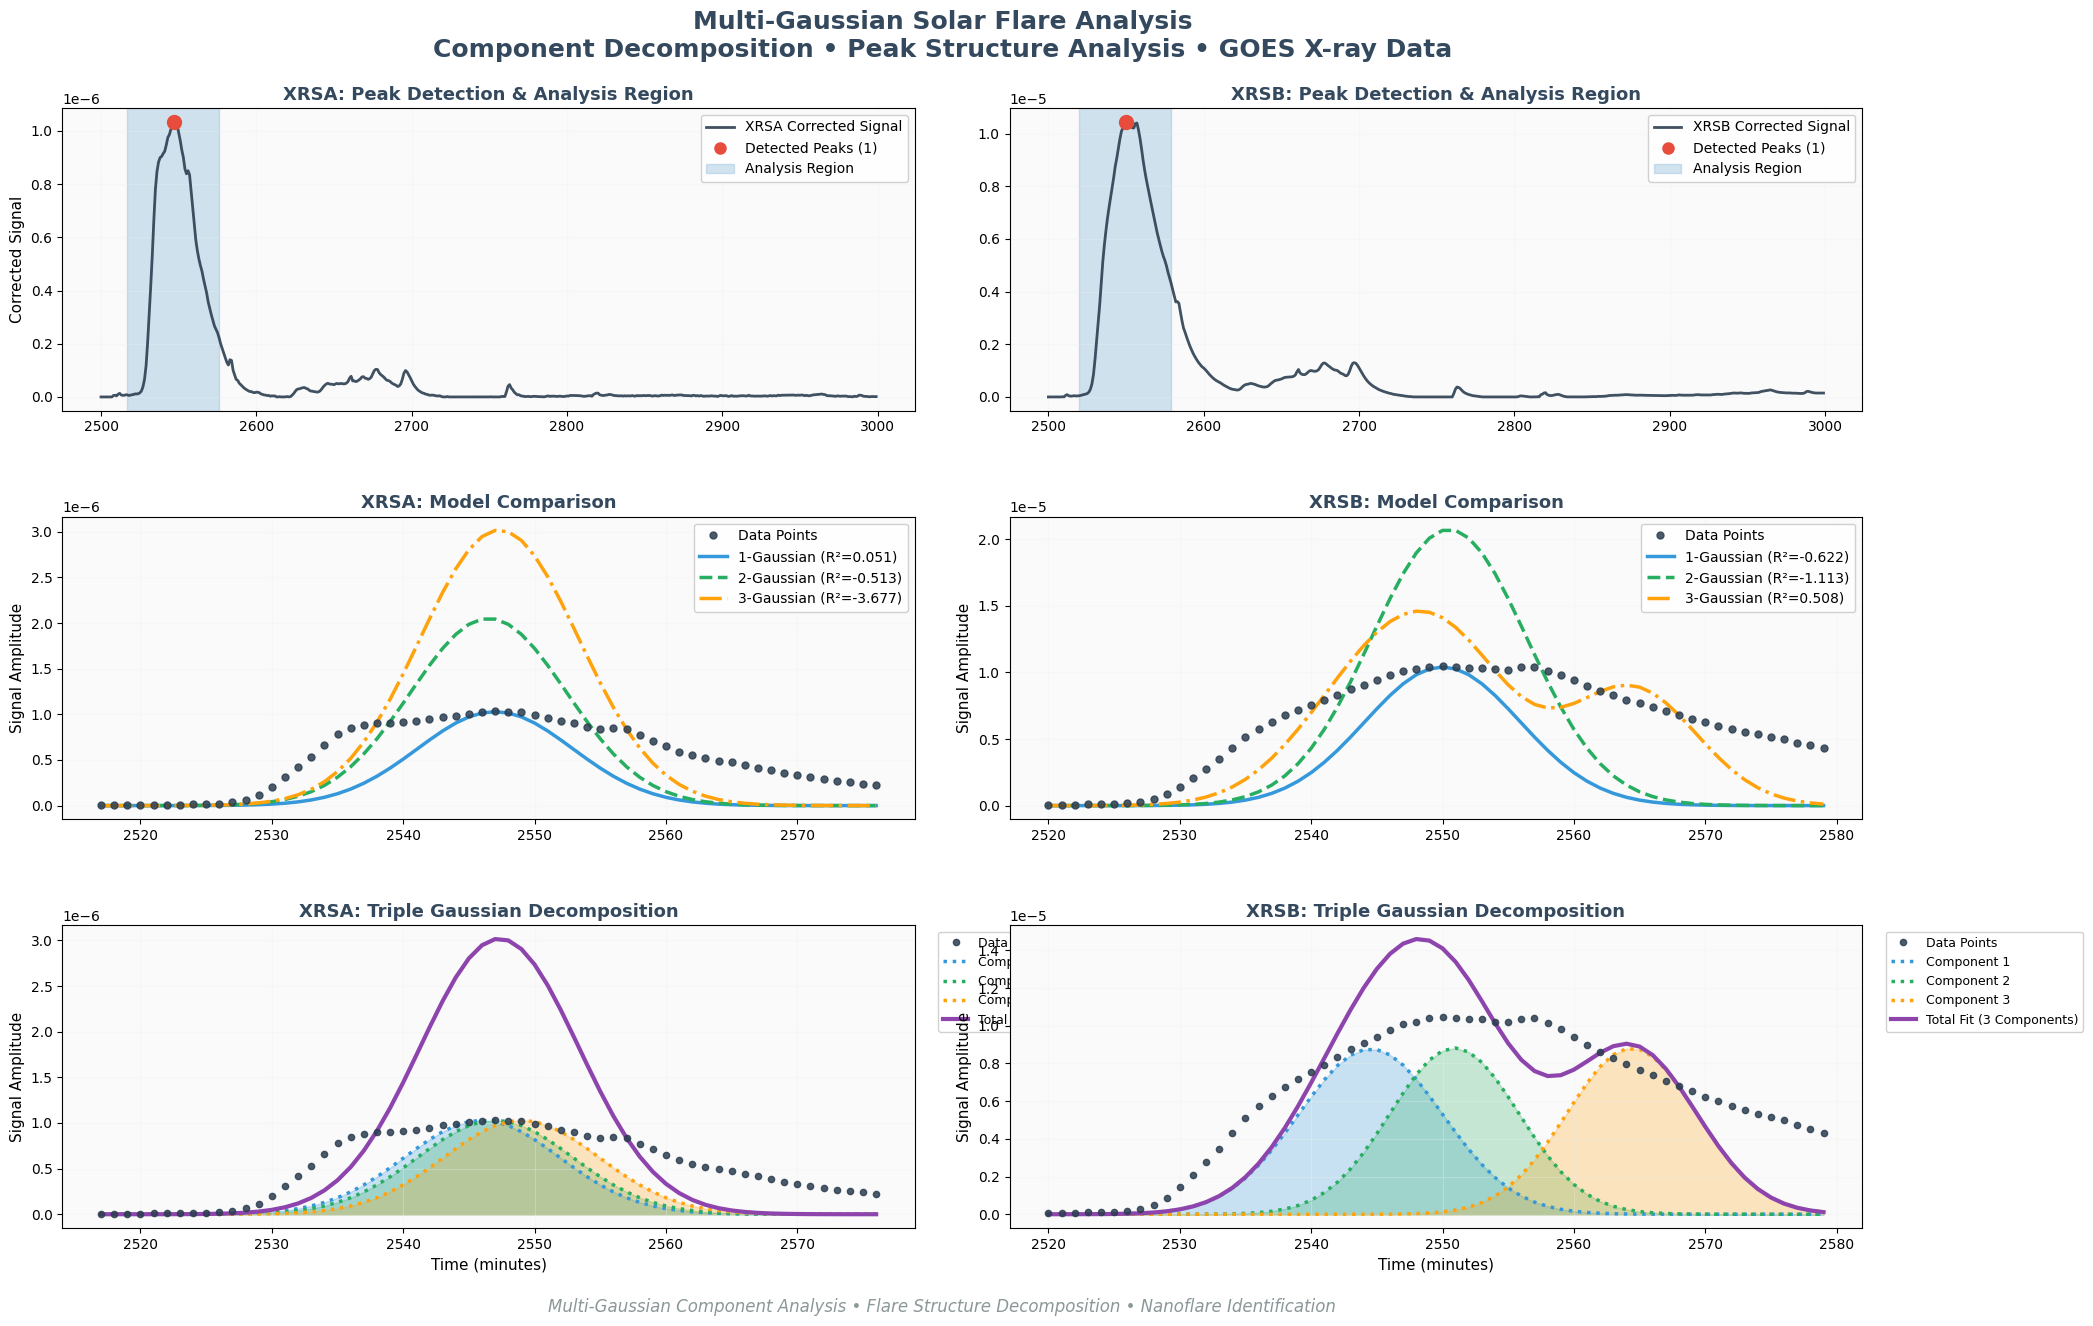

Overview figure generated.


In [18]:

# === RUN: choose highest peaks per channel, extract 60-min windows, generate figure ===
from scipy.signal import find_peaks

def choose_top_peak_and_window(series, time_minutes, window_min=60.0):
    # simple robust peak pick
    y = np.asarray(series, float)
    # use prominence to find candidates
    pk, props = find_peaks(y, prominence=np.nanstd(y)*2.0 if np.nanstd(y)>0 else 0.0, distance=5)
    if len(pk) == 0:
        # fallback: take global max
        top = int(np.nanargmax(y))
        pk = np.array([top])
    else:
        top = pk[np.argmax(y[pk])]
    start, end = extract_peak_region_by_minutes(y, time_minutes, top, window_min=window_min)
    return pk, top, time_minutes[start:end], y[start:end]

# Ensure required arrays exist (from earlier patch cell)
assert 'time_minutes' in globals(), "time_minutes missing"
assert 'xrsa_corrected' in globals() and 'xrsb_corrected' in globals(), "corrected arrays missing"

xrsa_peaks, xrsa_top, xrsa_peak_time, xrsa_peak_data = choose_top_peak_and_window(xrsa_corrected, time_minutes, 60.0)
xrsb_peaks, xrsb_top, xrsb_peak_time, xrsb_peak_data = choose_top_peak_and_window(xrsb_corrected, time_minutes, 60.0)

# Generate the figure
_ = make_overview_figure(
    time_minutes, xrsa_corrected, xrsb_corrected,
    xrsa_peak_time, xrsa_peak_data,
    xrsb_peak_time, xrsb_peak_data,
    xrsa_peaks_idx=xrsa_peaks, xrsb_peaks_idx=xrsb_peaks,
    xrsa_highest_idx=xrsa_top, xrsb_highest_idx=xrsb_top,
)
print("Overview figure generated.")


Starting batch: N=500 samples, block size=2000, output dir='./1970'


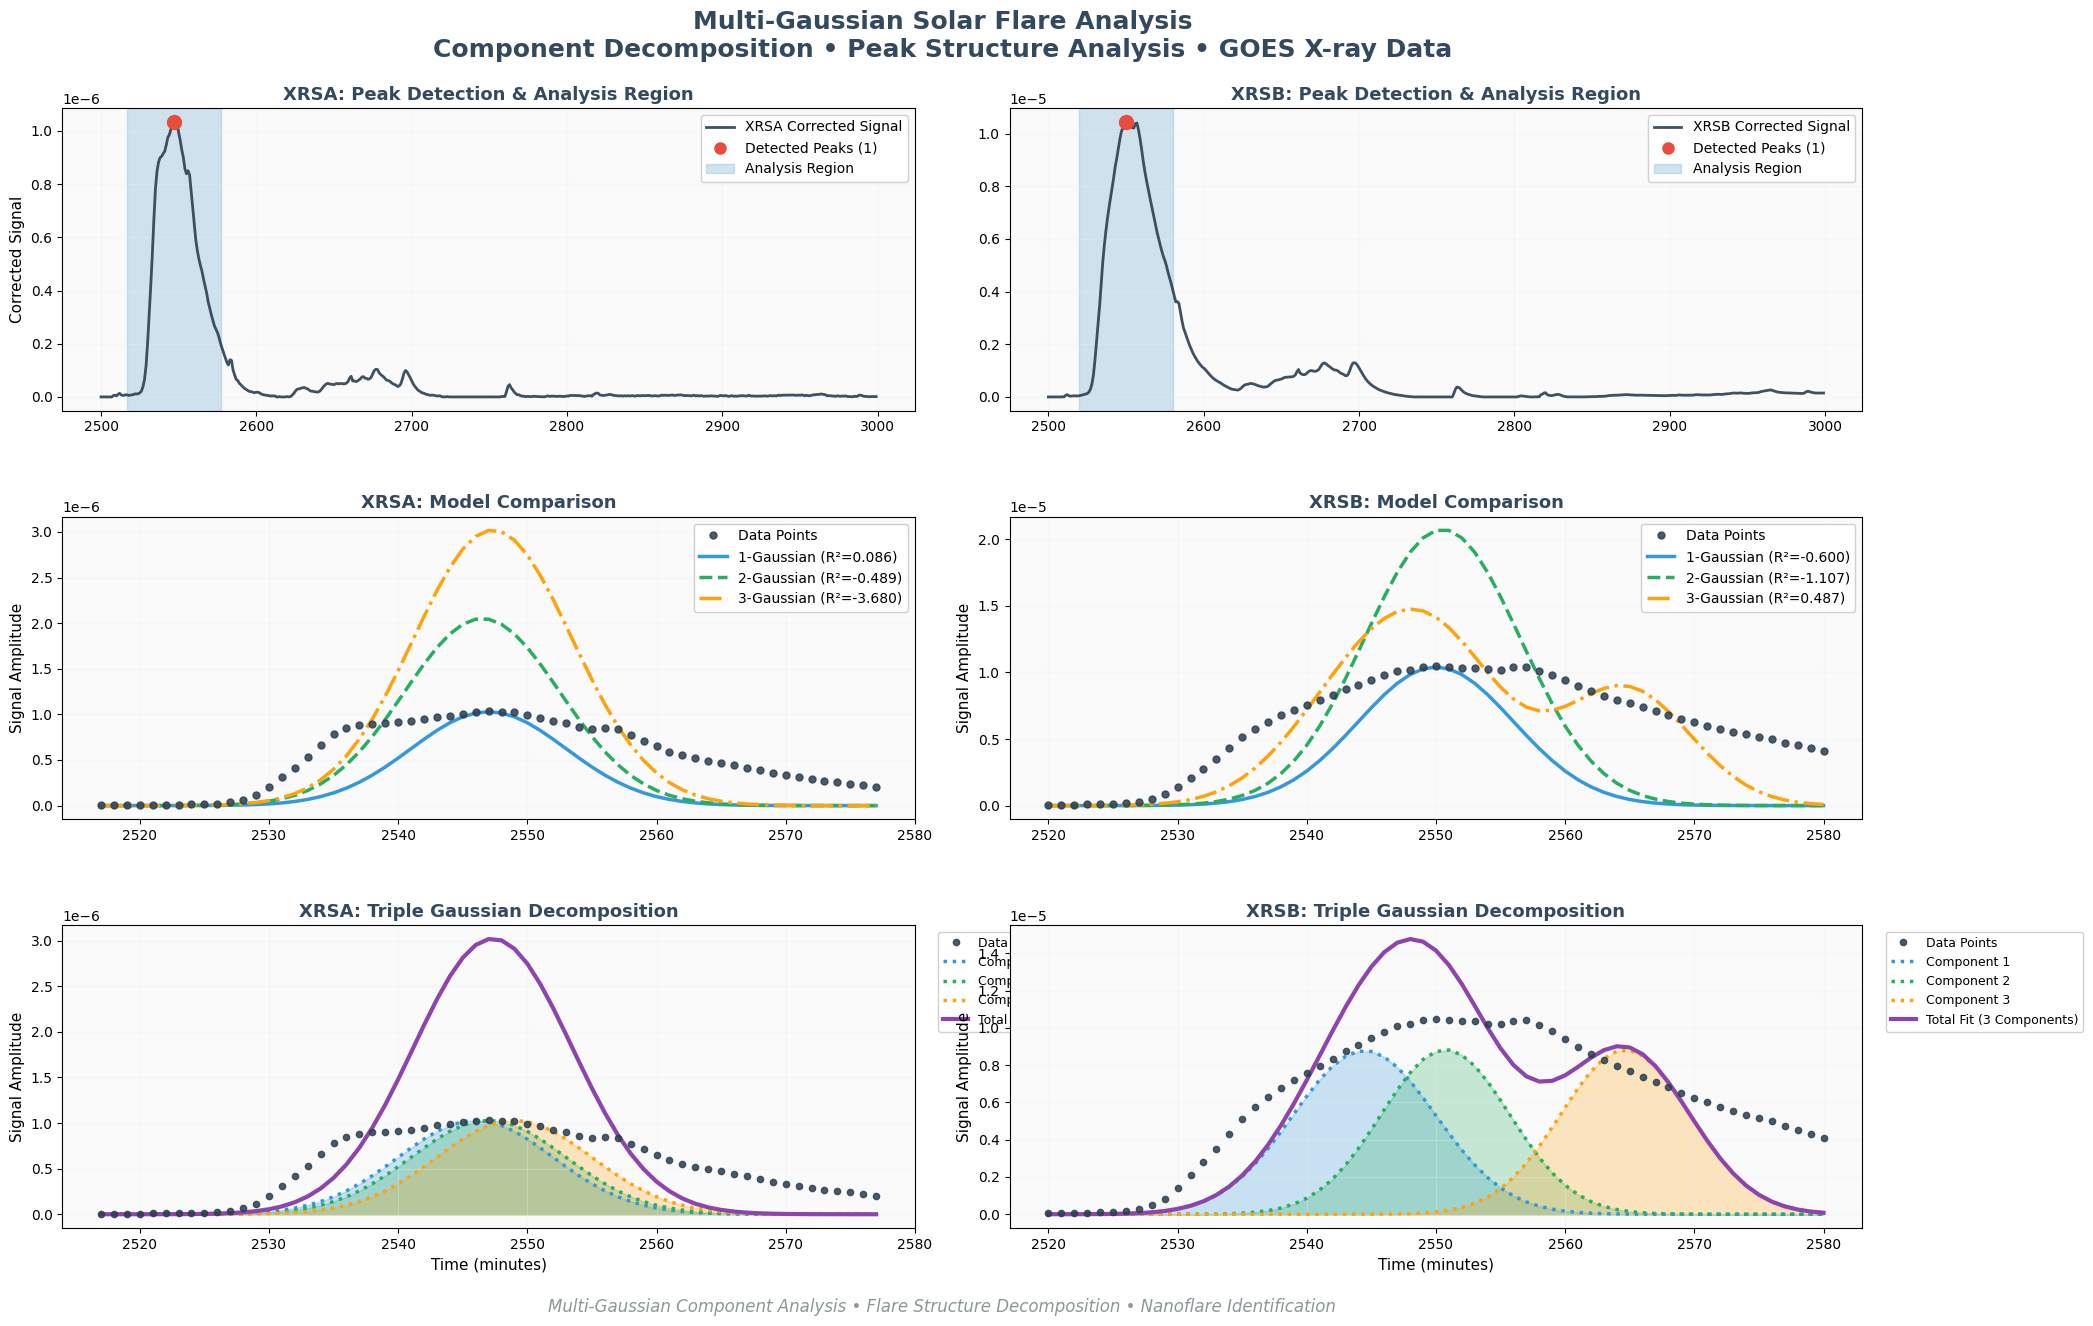

Batch complete. Saved 1 figures to './1970'.
Index written to: ./1970\1970_blocks_index.csv


In [19]:

# === BATCH RUN: generate 3×2 figures for 500-point blocks and save by year ===
import os
import numpy as np
import pandas as pd
from scipy.signal import find_peaks

# --- Config ---
WINDOW_MIN = 60.0         # analysis window around the highest peak in each block (minutes)
BLOCK_SIZE = 2000          # number of datapoints per block (0..499, 500..999, ...)
OUTDIR = None             # if None, will be set to "./<YEAR>"

# --- Derive YEAR from your dataframe index (fallback to 2017) ---
try:
    YEAR = int(pd.to_datetime(pd.Index(df.index)).min().year)
except Exception:
    YEAR = 2017

if OUTDIR is None:
    OUTDIR = f"./{YEAR}"

os.makedirs(OUTDIR, exist_ok=True)

def choose_top_peak_and_window_block(series_block, time_block, window_min=WINDOW_MIN):
    y = np.asarray(series_block, float)
    t = np.asarray(time_block, float)
    prom = np.nanstd(y)*2.0 if np.nanstd(y)>0 else 0.0
    pk, _ = find_peaks(y, prominence=prom, distance=5)
    if len(pk) == 0:
        top = int(np.nanargmax(y))
        pk = np.array([top])
    else:
        top = pk[np.argmax(y[pk])]
    start, end = extract_peak_region_by_minutes(y, t, top, window_min=window_min)
    # ensure end is inclusive for slicing local arrays
    return pk, top, t[start:end+1], y[start:end+1]

# --- Run over blocks ---
N = len(time_minutes)
start = 0
block_id = 0
saved_files = []

print(f"Starting batch: N={N} samples, block size={BLOCK_SIZE}, output dir='{OUTDIR}'")

while start < N:
    end = min(start + BLOCK_SIZE - 1, N - 1)  # inclusive end index (e.g., 0..499, 500..999)
    # Slice block
    t_blk    = time_minutes[start:end+1]
    xrsa_blk = xrsa_corrected[start:end+1]
    xrsb_blk = xrsb_corrected[start:end+1]

    # Peak & window per channel within this block
    xrsa_peaks, xrsa_top, xrsa_peak_time, xrsa_peak_data = choose_top_peak_and_window_block(xrsa_blk, t_blk)
    xrsb_peaks, xrsb_top, xrsb_peak_time, xrsb_peak_data = choose_top_peak_and_window_block(xrsb_blk, t_blk)

    # Generate figure for this block (uses block arrays so indices align)
    fig = make_overview_figure(
        t_blk, xrsa_blk, xrsb_blk,
        xrsa_peak_time, xrsa_peak_data,
        xrsb_peak_time, xrsb_peak_data,
        xrsa_peaks_idx=xrsa_peaks, xrsb_peaks_idx=xrsb_peaks,
        xrsa_highest_idx=xrsa_top, xrsb_highest_idx=xrsb_top,
    )

    # Save
    fname = f"{YEAR}_block_{start:06d}_{end:06d}.png"
    fpath = os.path.join(OUTDIR, fname)
    fig.savefig(fpath, dpi=150, bbox_inches="tight")
    plt.close(fig)
    saved_files.append(fpath)

    block_id += 1
    start = end + 1

print(f"Batch complete. Saved {len(saved_files)} figures to '{OUTDIR}'.")

# Optional: write an index CSV of saved files
idx_csv = os.path.join(OUTDIR, f"{YEAR}_blocks_index.csv")
pd.DataFrame({"file": saved_files}).to_csv(idx_csv, index=False)
print(f"Index written to: {idx_csv}")


[BATCH] YEAR=1970 | BLOCK_SIZE=1000 | WINDOW_MIN=60.0 min | OUTDIR='./2024'
[BATCH] Total samples: 500 → expected ~1 blocks


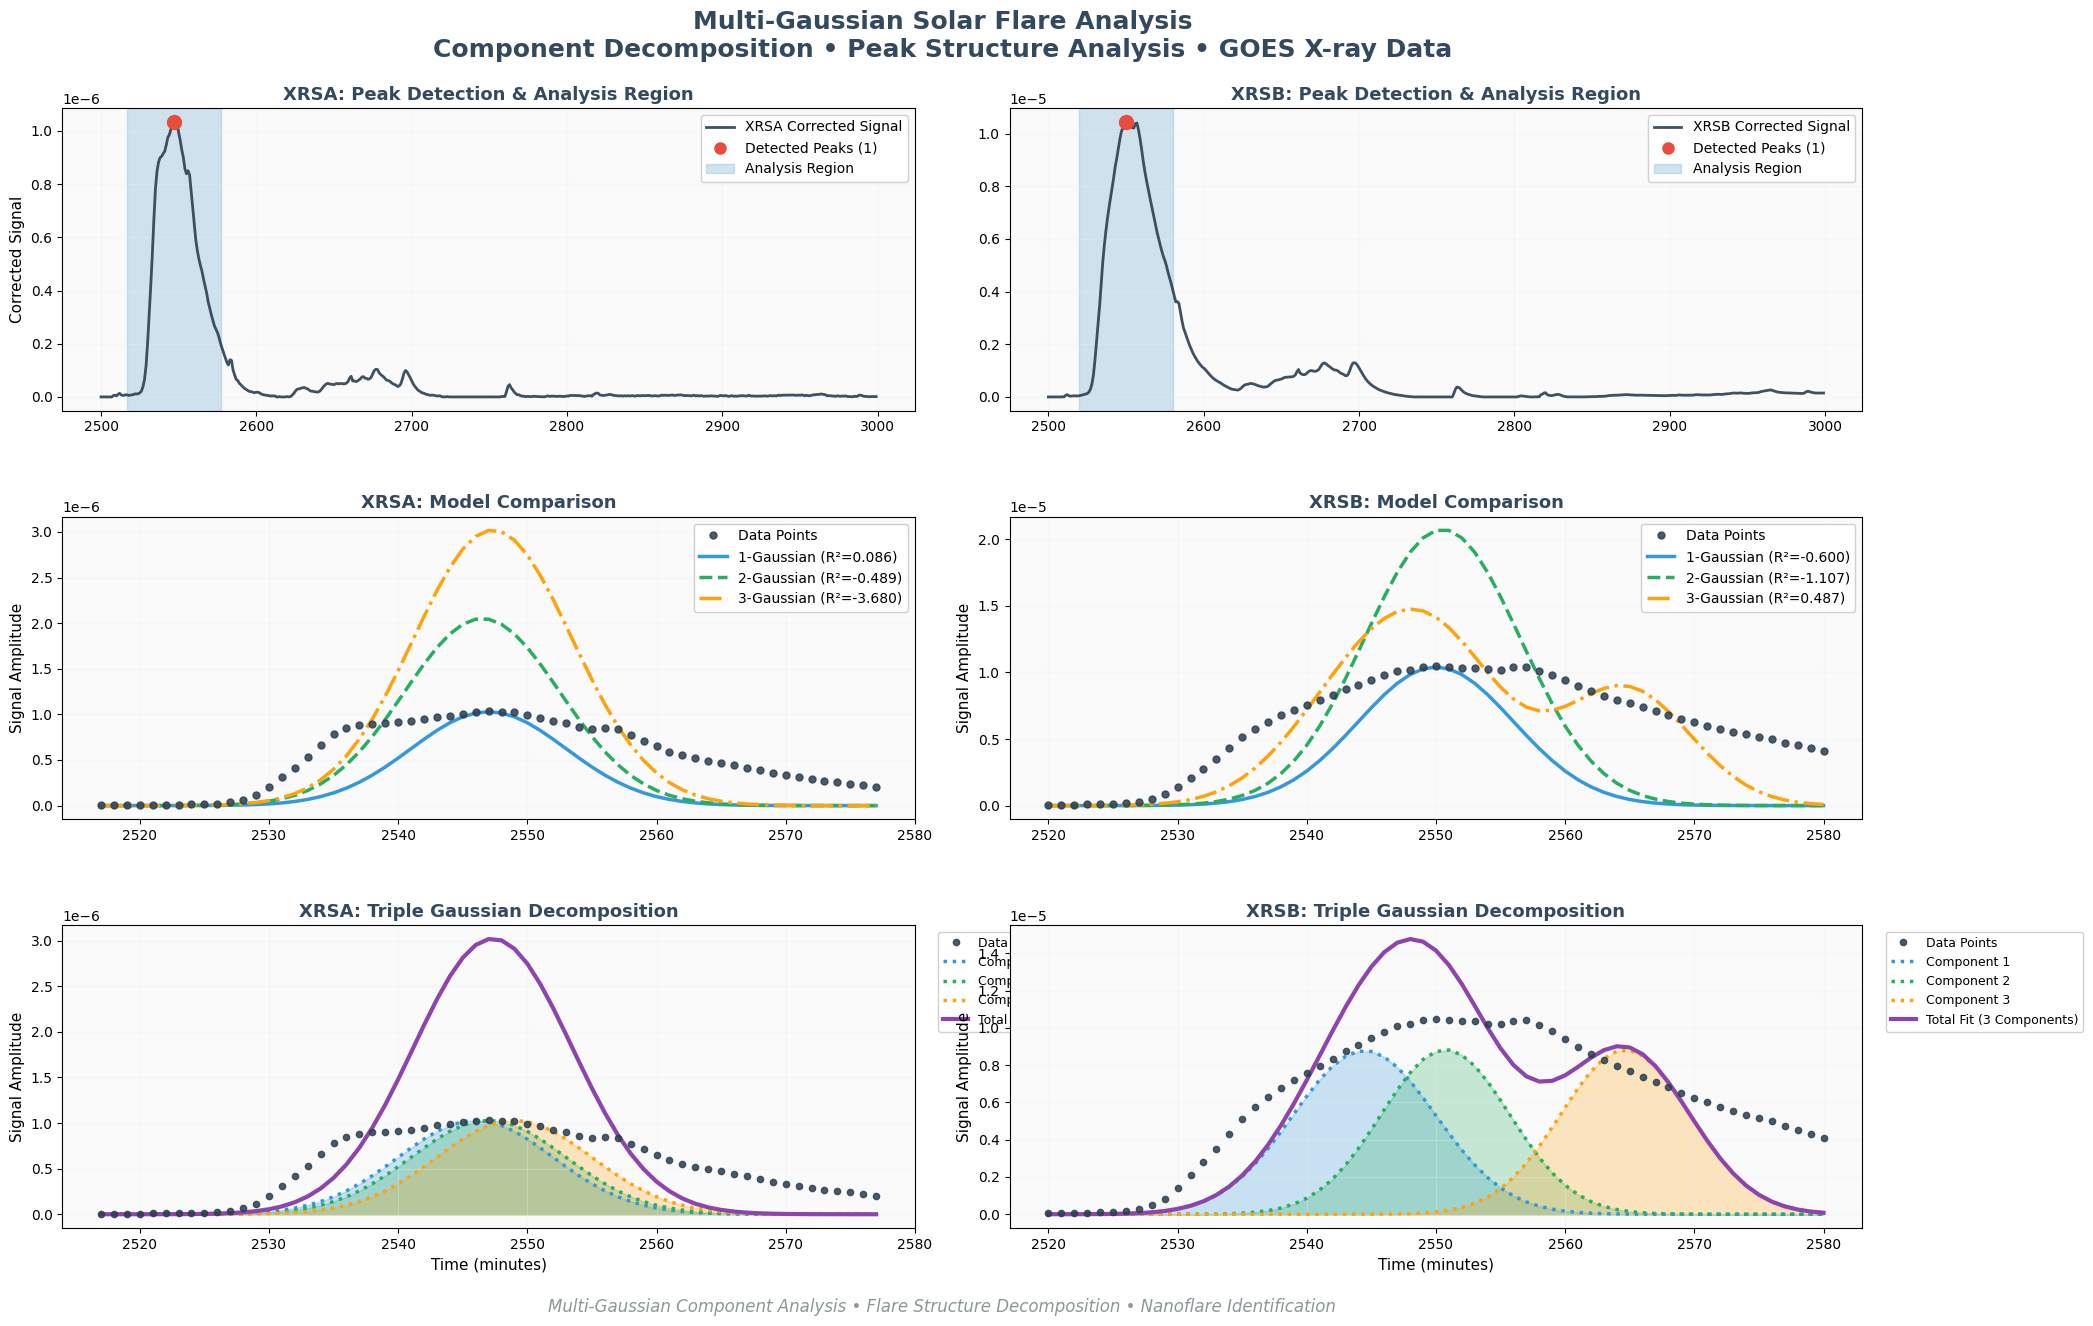

[BATCH] Saved: ./2024\1970_block_000000_000499.png
[BATCH] Done. Saved 1 figures. Index: ./2024\1970_blocks_index.csv


In [20]:
# === BATCH RUN (robust): 3×2 figures for blocks, saved under year folder ===
import os, re
import numpy as np
import pandas as pd
from scipy.signal import find_peaks

# ---------- CONFIG (read if already defined) ----------
# You can set these in a prior "config" cell:
#   DATA_FILES = [".../goes_xrs_2024.csv"]
#   YEAR = 2024
BLOCK_SIZE = 1000
WINDOW_MIN = 60.0
OUTDIR = "./2024"
BLOCK_SIZE = int(globals().get("BLOCK_SIZE", 500))
WINDOW_MIN = float(globals().get("WINDOW_MIN", 60.0))
OUTDIR     = globals().get("OUTDIR", None)

# ---------- YEAR inference with safe fallbacks ----------
def infer_year():
    # 1) explicit YEAR if provided
    if "YEAR" in globals():
        try:
            return int(globals()["YEAR"])
        except Exception:
            pass
    # 2) from DATA_FILES path
    if "DATA_FILES" in globals():
        for p in globals()["DATA_FILES"]:
            m = re.search(r"(20\d{2})", str(p))
            if m:
                return int(m.group(1))
    # 3) from df.index if datetime-like
    try:
        idx = pd.Index(df.index)
        if np.issubdtype(idx.dtype, np.datetime64):
            return int(pd.to_datetime(idx).min().year)
    except Exception:
        pass
    # 4) unknown
    return "unknown_year"

YEAR = infer_year()
if OUTDIR is None:
    OUTDIR = f"./{YEAR}"
os.makedirs(OUTDIR, exist_ok=True)

print(f"[BATCH] YEAR={YEAR} | BLOCK_SIZE={BLOCK_SIZE} | WINDOW_MIN={WINDOW_MIN} min | OUTDIR='{OUTDIR}'")

# ---------- Helper(s) reused from earlier cells ----------
def compute_dt_minutes(time):
    t = np.asarray(time, float)
    diffs = np.diff(t) if len(t)>1 else np.array([1.0])
    diffs = diffs[np.isfinite(diffs) & (diffs>0)]
    return float(np.median(diffs)) if len(diffs) else 1.0

def extract_peak_region_by_minutes(data, time, peak_idx, window_min=60.0):
    t = np.asarray(time, float)
    y = np.asarray(data, float)
    dt = compute_dt_minutes(t)
    half = int(round((window_min/2.0)/max(dt,1e-9)))
    start = max(0, int(peak_idx) - half)
    end   = min(len(y)-1, int(peak_idx) + half)
    if end - start < max(10, int(round(5/dt))):
        center = int(peak_idx)
        start = max(0, center - int(round(15/dt)))
        end   = min(len(y)-1, center + int(round(15/dt)))
    return start, end

def choose_top_peak_and_window_block(series_block, time_block, window_min=WINDOW_MIN):
    y = np.asarray(series_block, float)
    t = np.asarray(time_block, float)
    prom = np.nanstd(y)*2.0 if np.nanstd(y)>0 else 0.0
    pk, _ = find_peaks(y, prominence=prom, distance=5)
    if len(pk) == 0:
        top = int(np.nanargmax(y))
        pk  = np.array([top])
    else:
        top = int(pk[np.argmax(y[pk])])
    # Build minute-based window within the *block* timebase
    start_b, end_b = extract_peak_region_by_minutes(y, t, top, window_min=window_min)
    return pk, top, t[start_b:end_b+1], y[start_b:end_b+1]

# ---------- Sanity checks ----------
for var in ("time_minutes","xrsa_corrected","xrsb_corrected"):
    if var not in globals():
        raise RuntimeError(f"[BATCH] Missing '{var}'. Run loader/baseline patches first.")

N = len(time_minutes)
if N != len(xrsa_corrected) or N != len(xrsb_corrected):
    raise RuntimeError("[BATCH] time/series length mismatch.")

print(f"[BATCH] Total samples: {N} → expected ~{(N-1)//BLOCK_SIZE + 1} blocks")

# ---------- Main loop ----------
saved_files = []
for start in range(0, N, BLOCK_SIZE):
    end = min(start + BLOCK_SIZE, N)  # Python slice end is exclusive
    # slice block arrays
    t_blk    = time_minutes[start:end]
    xrsa_blk = xrsa_corrected[start:end]
    xrsb_blk = xrsb_corrected[start:end]

    if len(t_blk) == 0:
        continue

    xrsa_peaks, xrsa_top_rel, xrsa_peak_time, xrsa_peak_data = choose_top_peak_and_window_block(xrsa_blk, t_blk)
    xrsb_peaks, xrsb_top_rel, xrsb_peak_time, xrsb_peak_data = choose_top_peak_and_window_block(xrsb_blk, t_blk)

    # Convert relative index to *block* (for markers in row-1)
    xrsa_top = xrsa_top_rel
    xrsb_top = xrsb_top_rel

    # Build figure using the block arrays (so x-axis shows block context)
    fig = make_overview_figure(
        t_blk, xrsa_blk, xrsb_blk,
        xrsa_peak_time, xrsa_peak_data,
        xrsb_peak_time, xrsb_peak_data,
        xrsa_peaks_idx=xrsa_peaks, xrsb_peaks_idx=xrsb_peaks,
        xrsa_highest_idx=xrsa_top, xrsb_highest_idx=xrsb_top,
    )

    fname = f"{YEAR}_block_{start:06d}_{end-1:06d}.png"
    fpath = os.path.join(OUTDIR, fname)
    fig.savefig(fpath, dpi=150, bbox_inches="tight")
    plt.close(fig)
    saved_files.append(fpath)
    print(f"[BATCH] Saved: {fpath}")

# ---------- Index CSV ----------
idx_csv = os.path.join(OUTDIR, f"{YEAR}_blocks_index.csv")
pd.DataFrame({"file": saved_files}).to_csv(idx_csv, index=False)
print(f"[BATCH] Done. Saved {len(saved_files)} figures. Index: {idx_csv}")
